# **Installation of the RDKit**

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


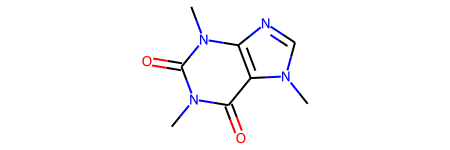

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
IPythonConsole.ipython_useSVG=True 
Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")




---


# Method configuration

In [3]:
#Center output
#from IPython.display import display, HTML
CSS = """
.output {
    align-items: center;
}
"""
#HTML('<style>{}</style>'.format(CSS))

# Enables large output display
#from IPython.core.display import display, HTML
#display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

#from google.colab import data_table
#data_table.enable_dataframe_formatter()

from IPython.display import display, HTML

def show(obj):
  display(HTML(obj.to_html(escape=False)))


In [5]:
from IPython.display import display
import dataset as cronos
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

###
# Consortium size
k = 8

params = {
    
    # experiment details
    'details' : 4,                  # level of detail of the experiment (low=1,medium=2,high=3,full=4)
    
    # datafiles
'training_data_file' : 'hERG_lhasa_training',
    'test_data_file' : 'hERG_lhasa_test',
    'test_data_file' : 'hERG_lhasa_test',
'transfer_data_file' : 'cronos_full',
  'cronos_label_file': 'cronos_labels',
    
    # data sampling
   'validation_ratio': 0.2,        # ratio validation/training
     'transfer_size' : 50000 ,      # sample for the transfer data (-1 = all)
         'test_size' : -1,          # sample for the test data (-1 = all)
     'training_size' : -1,          # sample for the training data (-1 = all)

    # number of teacher/clusters (kMean)
                 'k' : k,           # number of clusters (kMean)
     'smooth_factor' : 0.05,        # level of post-clustering mixing to avoid fully biased teachers
    
    # teachers
 'teacher_algorithm' : 'rf',        # algorithm used to build the teacher models
    
    # students
 'federated_student' : 'F' + str(k),
      'student_size' : 10000,                                              # size of the student (number of labelled Cronos data used)
      'student_sizes' : [100,250,500, 1000,2500,5000,10000,25000,50000],   # sizes of the student ti study the impact of the size
 'student_algorithm' : 'rf',                                               # default algorithm used to build the student models
      'student_mode' : 'balanced',                                         # default mode used to select the student data 
    
    # random seed for reproductibility
      'random_state' : 42,

    # t-SNE settings
         'tsne_size' : 500,
   'tsne_iterations' : 1000,
    
    # replication level
    'replicate_count' : 3,
    
    # fonts
       'figure_font' : dict(family="Arial",size=14,color="black"),
 'small_figure_font' : dict(family="Arial",size=10,color="black"),

    # colors
'figure_color_scale' : [(0,"red"),(0.2,"orange"), (0.3,'yellow'),(1,'green')],
        'bar_colors' : px.colors.qualitative.Prism,
         'green_map' : plt.get_cmap('Greens')
}

In [6]:
import importlib
importlib.reload(cronos)

<module 'dataset' from '/home/mit/work/test/dataset.py'>



---
# **From Private Data to Public Knowledge**
---

## Abstract

In this note book, we demonstrate a data driven federated learning using the Teacher-Student approach to transfer knowledge from confidential data into public knowledge whilst preserving the privacy of the source data.

We use the hERG endpoint to validate the concept in the context of a classification task. 

- The sources of knowledge to federate are simulated by clustering a set of curated ChEMBL data into subspaces representing different chemical domains

- Using a k-mean algortihm and FCFP2 as the domain representation, we split the ChEMBL data into k different clusters, each cluster representing a virtual member of the federation.

- Next, we train k teachers models from the associated cluster data. Thiese teacher models represent private models that can be trained within the private space of each federation member.

- We then annotate a large collection (100k) of unlabelled public data  using these teachers (one label/teachers) leading to a matrix of k labels for each structure. The collection of unlabbeled data is call the transfer data.

- We consolidate the k labels into a single federated label using an a weighted average scheme over the classe probabilityies across the k labels. This step results in a new dataset of 100k structures annotated with a federated label; this label can be seen as a surrogate for an experimental label.

- Next we build a student model using the annotated transfer data as a training set

- In order to validate the approach, we compare the performance of the teachers models with the student model. More specififically we will use the Mathew Correlation Coefficient (MCC) as the accuracy metric and compare the average teacher performance woth the student performance when validated against an external test set.

- If the student is performing better than the average teacher performance we consider the concept as validated

The idea is to demonstrate that although the teachers capture source knowledge about different chemical spaces (cluster separation), the student will be able to federate the knowledge across the teachers and outperform individual teachers when validated against an external  dataset 

We will also look at different aspects of this experiment like the individual contribution of each teacher, the impact of the number of teachers, the size of the transfer data set, etc.

## Data preparation

We will uses three datasets:

- Public ChEMBL hERG data as a source of knowledge for the teachers
- Preissner as benchmark data from the [Preissner et al. paper](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00150)
- Cronos as transfer data

We are going to use ChEMBL hERG data as the source for the teachers' data. The ChEMBL data will be clustered to simulate different sources (teachers) covering distinct chemical spaces. Dupplicates are removed.

As we load the datasets we create an activity table and compute the fingerprints

We use the Preissner dataset as an external test set to benchmark our teachers and students. Preissner compounds overlapping with ChEMBL data are removed. We also make sure there are no internal dupplicates (including stereo-isomers and tautomers).

Cronos is our dataset prepared from 100 millions Puch Chem structures sampled down to 1M and further tiled down to 350k structures that evenly cover the PuchChem space and hence represents a large homogeneous chemical space.

In [7]:
####
# Load and prepare the data
# if force_sdf True we force reloading from the SDF files
force_sdf = False 
training_full = cronos.load_training_data(params, force_sdf)
test_full = cronos.load_test_data(params, force_sdf)
transfer_full = cronos.load_transfer_data(params, force_sdf)

From pickle training data size = 7772
From pickle test data size = 4383
From pickle transfer data size = 347717


Sampling the data according to the experiment configuration:

In [8]:
####
# Sample the desired size of data according to the experiment parameters
training_data, test_data, transfer_data, validation_data = cronos.sample_data(training_full, test_full, transfer_full, params)

Validation data size = 1554
Training data size = 6218
Test data size = 4383
Transfer data size = 50000


## Creating Teachers
### Teacher source space

We use the ChEMBL training dataset as the source space for the teachers. 
Here we see the global activity distribution of the source data.

In [9]:
%matplotlib inline
import plotly.io as pio
pio.renderers.default = "iframe"

In [10]:
####
# Use the training data as teacher source space
# and plot the class distribution in this space
teacher_space = training_data
cronos.display_distribution(teacher_space,'ACTIVITY',"Source space class distribution")

### Create teacher data

Next we create k teachers using k clusters from the ChEMBL training data using kMean clustering.
We use the Scikit Learn kMean implementation. *Unfortunately the default and only distance metric in this version is Euclidian but ideally we would like to work with the Tanimoto similarity.*

As we can see in the bar plot below, the k clusters are distributed into different sizes and different bias between active and inactive compounds. This gives us a good variety of virtual contributors to the federated model and fits with a real world situation.

We extract the teacher data from the ChEMBL clusters; each cluster provides the data for one individual teacher. We have added one special teacher T0 (not used in the federation process) that is trained on all the ChEMBL data. T0 will allow us to have a reference point to measure the performance we would obtain if we directly build a model using all the data, in other words, this would be the best performance (upper bound) we can expect if we had access to all the private data without confidentiality protection nor need for federation.

In [11]:
####
# Cluster the source data into k teacher training sets
teacher_data = cronos.cluster_data_space(teacher_space, 'Teacher', 'T', params['k'], params['smooth_factor'], params)


Clustering data k = 8


,Teacher,Active,Inactive,Total,Proportion (%)
0,T0,2912,3306,6218,100.000000
1,T1,116,138,254,4.084915
2,T2,230,28,258,4.149244
3,T3,635,336,971,15.615954
4,T4,74,112,186,2.991316
5,T5,294,736,1030,16.564812
6,T6,698,1169,1867,30.025732
7,T7,129,152,281,4.519138
8,T8,736,635,1371,22.048890


### Teacher space projection

We can see that the k cluster have separate chemical space which will make the experiment challenging: "Will the federated student be able to rebuild a global chemical space knowledge by learning from the relatively disjoint teacher chemical spaces.

We can observe that some cluster are strongly biased towards a specific class whilst others are more balanced. This again gives us a good simulation of the real world.

In [12]:
cronos.project_teacher_cluster_space(training_data, params)

In [13]:
cronos.project_teacher_activity_space(training_data, params)

### Transfer space projection

Here can verify that the training, test and transfer spaces overlap. Also the test space is relatively well spread accross the training space whilst being external.

In [14]:
cronos.plot_transfer_space(training_data, test_data, transfer_data, params)

In [15]:
cronos.plot_data_space([(transfer_data, "transfer", 1000), (training_data,"training", 500)], params)

In [16]:
datasets = [(transfer_data, "transfer", 5000)] +[ (teacher_data[i], "T" + str(i), 100) for i in range(1, 1+params['k'])]

cronos.plot_data_space(datasets, params)

In [17]:
datasets = [(transfer_data, "transfer", 1000)] + [ (pd.concat([ teacher_data[i] for i in range(1, 1+params['k'])]), "teachers", 500)]

cronos.plot_data_space(datasets, params)

### Building the teacher models

We use the selected machine learning algorithm to build a model for each teacher.

In [18]:
teacher_models = cronos.build_teacher_models(teacher_data, params)

  0%|          | 0/9 [00:00<?, ?it/s]

### Teachers internal cross-validation

Not suprisingly the teacher's internal validation display relatively good performances with an MCC ~= 0.5

In [19]:
cronos.cross_validate_teachers(teacher_data, params)

Performing teacher cross-validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,4974,0.750970,0.752010,0.501981,0,0.735052,0.734547,0.767393,0.735557,0.766465,0.750970
1,T1,203,0.703336,0.700787,0.405256,0,0.691057,0.732759,0.673913,0.653846,0.750000,0.703336
2,T2,206,0.670342,0.887597,0.371874,0,0.937634,0.947826,0.392857,0.927660,0.478261,0.670342
3,T3,776,0.690511,0.744593,0.410348,0,0.816024,0.866142,0.514881,0.771388,0.670543,0.690511
4,T4,148,0.726110,0.741935,0.456874,0,0.666667,0.648649,0.803571,0.685714,0.775862,0.726110
5,T5,824,0.794634,0.834951,0.592962,0,0.707904,0.700680,0.888587,0.715278,0.881402,0.794634
6,T6,1493,0.708400,0.742903,0.435772,0,0.624413,0.571633,0.845167,0.687931,0.767677,0.708400
7,T7,224,0.837898,0.839858,0.677144,0,0.823529,0.813953,0.861842,0.833333,0.845161,0.837898
8,T8,1096,0.721689,0.726477,0.448141,0,0.755382,0.786685,0.656693,0.726474,0.726481,0.721689


### Teachers  validation on the ChEMBL space

The performance of the teacher against the external Preissner test set allows us to conclude that the teacher models slightly overfit in their respective focused chemical space. Their performance is on average lower when tested against a more global chemical space as in the Preissner test set.

In [20]:
teacher_validation_table, teacher_average_table = cronos.validate_teachers(teacher_models, validation_data, params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,6218,0.765873,0.765122,0.530324,0,0.753212,0.775766,0.755981,0.731932,0.796974,0.765873
1,T1,254,0.554346,0.529601,0.141588,0,0.633584,0.880223,0.228469,0.494910,0.689531,0.554346
2,T2,258,0.544910,0.567568,0.112332,0,0.345029,0.246518,0.843301,0.574675,0.565811,0.544910
3,T3,971,0.657400,0.654440,0.314351,0,0.650618,0.696379,0.618421,0.610501,0.703401,0.657400
4,T4,186,0.565178,0.584299,0.151477,0,0.410584,0.313370,0.816986,0.595238,0.580782,0.565178
5,T5,1030,0.616170,0.635779,0.274030,0,0.475926,0.357939,0.874402,0.709945,0.613255,0.616170
6,T6,1867,0.687839,0.697555,0.390732,0,0.631083,0.559889,0.815789,0.723022,0.683367,0.687839
7,T7,281,0.608992,0.620335,0.229038,0,0.528000,0.459610,0.758373,0.620301,0.620352,0.608992
8,T8,1371,0.657705,0.662806,0.318515,0,0.618076,0.590529,0.724880,0.648318,0.673333,0.657705


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.611567,0.619048,0.241508,0.0,0.536613,0.513057,0.710078,0.622114,0.641229,0.611567
1,T-max,1867.00,0.687839,0.697555,0.390732,0.0,0.650618,0.880223,0.874402,0.723022,0.703401,0.687839
2,T-min,186.00,0.544910,0.529601,0.112332,0.0,0.345029,0.246518,0.228469,0.494910,0.565811,0.544910
3,T-std,NaN,0.053377,0.055383,0.099637,0.0,0.116070,0.211946,0.210528,0.073558,0.052868,0.053377


### Teachers  validation on the Preissner space

The performance of the teacher against the external Preissner test set allows us to conclude that the teacher models slightly overfit in their respective focused chemical space. Their performance is on average lower when tested against a more global chemical space as in the Preissner test set.

In [21]:
teacher_validation_table, teacher_average_table = cronos.validate_teachers(teacher_models, test_data, params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,6218,0.776903,0.857632,0.596997,0,0.681957,0.617159,0.936647,0.761959,0.881598,0.776903
1,T1,254,0.632947,0.488478,0.255139,0,0.470477,0.918819,0.347075,0.316190,0.928629,0.632947
2,T2,258,0.546309,0.762720,0.186259,0,0.197531,0.118081,0.974538,0.603774,0.770798,0.546309
3,T3,971,0.754741,0.794433,0.483104,0,0.619349,0.676199,0.833283,0.571317,0.886774,0.754741
4,T4,186,0.587117,0.767739,0.252198,0,0.328496,0.229705,0.944529,0.576389,0.788661,0.587117
5,T5,1030,0.613488,0.796715,0.360804,0,0.379094,0.250923,0.976053,0.774929,0.798611,0.613488
6,T6,1867,0.674235,0.814967,0.442094,0,0.514080,0.395756,0.952713,0.733333,0.827541,0.674235
7,T7,281,0.617684,0.774127,0.301019,0,0.402895,0.308118,0.927251,0.581882,0.803098,0.617684
8,T8,1371,0.710652,0.791467,0.429583,0,0.566414,0.550738,0.870567,0.583008,0.855016,0.710652


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.642147,0.748831,0.338775,0.0,0.434792,0.431042,0.853251,0.592603,0.832391,0.642147
1,T-max,1867.00,0.754741,0.814967,0.483104,0.0,0.619349,0.918819,0.976053,0.774929,0.928629,0.754741
2,T-min,186.00,0.546309,0.488478,0.186259,0.0,0.197531,0.118081,0.347075,0.316190,0.770798,0.546309
3,T-std,NaN,0.067736,0.106595,0.106512,0.0,0.136621,0.267164,0.210579,0.136539,0.054063,0.067736


## Annotating the transfer data

### Labeling the Cronos transfer data

When annotating the tranferdata, we associate each public structure with a hERG predicted label. Each label is expressed as a probability distribution between the ACTIVE and INACTIVE classes and it is therefore interesting to analyse how these to classes are distributed over the whole transfer data

In [22]:
force_annotation = True
label_table = cronos.annotate_transfer_data(transfer_data, teacher_models, teacher_data, params, force_annotation)

Labelling the Cronos data...


  0%|          | 0/9 [00:00<?, ?it/s]

Analysing teacher contribution similarities...
 Min:2.498696190198128
 Max:10.011681621386003
Computing teacher contribution weights...


  0%|          | 0/8 [00:00<?, ?it/s]

Normalizing teacher contribution weights...


  0%|          | 0/8 [00:00<?, ?it/s]

This value : 0.9999999999999999 should be very close to 1.0
Cronos label table shape : (50000, 47)


### Federating the labels

In [23]:
label_table = cronos.federate_teacher_annotations(label_table, params)

(50000, 51)

In [24]:
cronos.plot_annotation_distributions(label_table, 800, 600, params)

In [25]:
cronos.compute_teacher_probability_distributions(label_table, params)

,Teacher,min,mean,max,std
0,T0,0.500016,0.663325,0.974000,0.103034
1,T1,0.500002,0.576909,0.839345,0.053509
2,T2,0.500000,0.702710,0.946667,0.091170
3,T3,0.500000,0.562520,0.850102,0.048692
4,T4,0.500009,0.605701,0.883060,0.068591
5,T5,0.500018,0.701936,0.985732,0.115712
6,T6,0.500003,0.612646,0.849073,0.069483
7,T7,0.500002,0.595381,0.999840,0.058042
8,T8,0.500001,0.577070,0.817566,0.057058


In [26]:
cronos.plot_confidence_distributions(label_table, 900,800, params)

## Building the student training data
We now have a full set of non sensitive transfer data annotate by a federation of k teachers. We could use all this data to build a student model or we can ask ourselves if it is preferable to select a subset of data that would allow us to reduce the cost of building the student model and potentially to improve the performance of the student by selecting only the *best* data. We can therefore define what is a good data point and on that basis explore the performance of the student as the number of selected point increases.

### Selecting the student data points

#### Assertiveness ('best') 
The most intuitive criteria for selecting student training data from the annotated transfer data is the assertiveness of the label associated to the data. The label is the result of the consolidation of the individual labels provided by the individual teacher. The probability distribution of the class is a good indicator of the assertiveness resulting from the ensemble of teacher. If the probability of the most likely class is close to 1.0 (100%) than the all the teachers agreed and were themselves assertive and we could think that this is worth contributing to the training of our student. On the other hand if this probability is close to 0.5 (50%), either the teacher were in disagreement or they were not assertive or both and the data point does not seem to be valuable. We will therfore in a first instance select the data points with the highest probabvility of the most likely class. The inconvenient with this selection mode is that the most confident labels are not distributed evenly accross the Cronos space and this creates a weaker coverage of the chemical space.

#### Max diversity ('random', 'balanced') 
Another criteria can be to maximize the coverage of the chemical space. Since the Cronos space is diverse and homogeneous we can simply pick randomly points in this space ('random'). The inconvenient of this selection method is that the decidability level of the points is arbitrary and the class may be not balanced. The latter is taken into account by taking the same number of instances from each classes ('balanced')

#### Assertive and diverse ('mixed')
If we want to combine assertiveness with diversity we can select randomnly a batch of points and subsequently cluster theses points in separate chemical spaces, then we can select from each cluster a subset of the most assertive points. We repeat this operation until we have collected the desired number of Cronos points. This approach select assertive and diverse points from the Cronos space.

#### Non assertivess ('worst')
In order to have a base line we introduce a selection method that select the least assertive data points in the Cronos space. This will combine the weakenesses of 'best' and 'random' and shall provide a good base line to improve.

In [27]:


student_validation_table, teacher_validation_table, hybrid_data, hybrid_models = cronos.benchmark(label_table, teacher_models, validation_data, params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,6218,0.765873,0.765122,0.530324,0,0.753212,0.775766,0.755981,0.731932,0.796974,0.765873
1,T1,254,0.554346,0.529601,0.141588,0,0.633584,0.880223,0.228469,0.494910,0.689531,0.554346
2,T2,258,0.544910,0.567568,0.112332,0,0.345029,0.246518,0.843301,0.574675,0.565811,0.544910
3,T3,971,0.657400,0.654440,0.314351,0,0.650618,0.696379,0.618421,0.610501,0.703401,0.657400
4,T4,186,0.565178,0.584299,0.151477,0,0.410584,0.313370,0.816986,0.595238,0.580782,0.565178
5,T5,1030,0.616170,0.635779,0.274030,0,0.475926,0.357939,0.874402,0.709945,0.613255,0.616170
6,T6,1867,0.687839,0.697555,0.390732,0,0.631083,0.559889,0.815789,0.723022,0.683367,0.687839
7,T7,281,0.608992,0.620335,0.229038,0,0.528000,0.459610,0.758373,0.620301,0.620352,0.608992
8,T8,1371,0.657705,0.662806,0.318515,0,0.618076,0.590529,0.724880,0.648318,0.673333,0.657705


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.611567,0.619048,0.241508,0.0,0.536613,0.513057,0.710078,0.622114,0.641229,0.611567
1,T-max,1867.00,0.687839,0.697555,0.390732,0.0,0.650618,0.880223,0.874402,0.723022,0.703401,0.687839
2,T-min,186.00,0.544910,0.529601,0.112332,0.0,0.345029,0.246518,0.228469,0.494910,0.565811,0.544910
3,T-std,NaN,0.053377,0.055383,0.099637,0.0,0.116070,0.211946,0.210528,0.073558,0.052868,0.053377


Benchmarking student for mode 'balanced'


  0%|          | 0/10 [00:00<?, ?it/s]

/!\ Student data not balanced for selection mode 'balanced', 4526 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2413 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 3874 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 4108 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2703 actives and  5000 inactives


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,S-T0,10000,0.646758,0.644788,0.292796,0,0.636364,0.672702,0.620813,0.603750,0.688329,0.646758
1,S-T1,10000,0.566652,0.546332,0.156185,0,0.629532,0.834262,0.299043,0.505485,0.677507,0.566652
2,S-T2,10000,0.525631,0.543758,0.058314,0,0.367529,0.286908,0.764354,0.511166,0.555169,0.525631
3,S-T3,10000,0.624660,0.615830,0.254476,0,0.640578,0.740947,0.508373,0.564157,0.695581,0.624660
4,S-T4,10000,0.576850,0.582368,0.155181,0,0.527312,0.504178,0.649522,0.552672,0.604004,0.576850
5,S-T5,10000,0.606788,0.617117,0.222401,0,0.531865,0.470752,0.742823,0.611212,0.620380,0.606788
6,S-T6,10000,0.686001,0.684685,0.370937,0,0.673333,0.703343,0.668660,0.645780,0.724093,0.686001
7,S-T7,10000,0.636015,0.627413,0.277186,0,0.650151,0.749304,0.522727,0.574173,0.708266,0.636015
8,S-T8,10000,0.630035,0.620978,0.265757,0,0.646246,0.749304,0.510766,0.568110,0.703460,0.630035
9,S-F8,10000,0.676522,0.673745,0.352403,0,0.668844,0.713092,0.639952,0.629766,0.721997,0.676522


/!\ Student data not balanced for selection mode 'balanced', 2703 actives and  5000 inactives


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,H0,10000,0.753067,0.747748,0.507302,0,0.750953,0.823120,0.683014,0.690421,0.818052,0.753067
1,H1,10000,0.685493,0.683398,0.370051,0,0.675462,0.713092,0.657895,0.641604,0.727513,0.685493
2,H2,10000,0.680414,0.678250,0.359944,0,0.670619,0.708914,0.651914,0.636250,0.722812,0.680414
3,H3,10000,0.690376,0.688546,0.379724,0,0.679470,0.714485,0.666268,0.647727,0.730971,0.690376
4,H4,10000,0.676129,0.673745,0.351469,0,0.667104,0.707521,0.644737,0.631056,0.719626,0.676129
5,H5,10000,0.690556,0.687259,0.380651,0,0.684416,0.733983,0.647129,0.641119,0.739071,0.690556
6,H6,10000,0.714126,0.708494,0.429910,0,0.714196,0.788301,0.639952,0.652826,0.778748,0.714126
7,H7,10000,0.696439,0.693694,0.392097,0,0.688482,0.732591,0.660287,0.649383,0.741935,0.696439
8,H8,10000,0.697020,0.693050,0.394002,0,0.692853,0.749304,0.644737,0.644311,0.749652,0.697020
9,H0-F8,10000,0.753370,0.748391,0.507461,0,0.750479,0.818942,0.687799,0.692580,0.815603,0.753370


In [28]:
importlib.reload(cronos)

teachers = [t for t in range(1, 9)]

JPselected_data = cronos.select_federated_data(label_table, teachers, 10000, params)

JPhybrid_data = []

print("teacher")

for data in teacher_data:
    print(data.shape)
    JPhybrid_data.append(pd.concat([data, JPselected_data]))


print(len(JPhybrid_data))

print("hybrid")
for data in JPhybrid_data:
    print(data.shape)

JPhybrid_models = []

print("learning models")
for data in JPhybrid_data:
    JPhybrid_models.append(cronos.create_trained_classifier('rf', data))

print(len(JPhybrid_models))
                           
    

/!\ Student data not balanced for selection mode 'balanced', 2703 actives and  5000 inactives
teacher
(6218, 10)
(254, 10)
(258, 10)
(971, 10)
(186, 10)
(1030, 10)
(1867, 10)
(281, 10)
(1371, 10)
9
hybrid
(13921, 53)
(7957, 53)
(7961, 53)
(8674, 53)
(7889, 53)
(8733, 53)
(9570, 53)
(7984, 53)
(9074, 53)
learning models
9


In [29]:
importlib.reload(cronos)
cronos.ADbenchmark(teacher_data, JPhybrid_data, teacher_models, JPhybrid_models, validation_data, radius = 2)

Gathering Feature Dictionaries
teacher
hybrid
Appending AD information to table
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Predicting teacher models
Predicted_T0
Predicted_T1
Predicted_T2
Predicted_T3
Predicted_T4
Predicted_T5
Predicted_T6
Predicted_T7
Predicted_T8
Predicting hybrid models
Predicted_H0
Predicted_H1
Predicted_H2
Predicted_H3
Predicted_H4
Predicted_H5
Predicted_H6
Predicted_H7
Predicted_H8
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=129296286)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=130248447)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1332718787)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=493282365)
DecisionTreeClassifier(max_depth=1

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,131,0.721009,0.763359,0.473080,0,0.635294,0.562500,0.879518,0.729730,0.776596,0.721009
1,HM_0,131,0.759413,0.778626,0.521185,0,0.694737,0.687500,0.831325,0.702128,0.821429,0.759413
2,TM_1,713,0.565674,0.584853,0.177642,0,0.696099,0.899204,0.232143,0.567839,0.672414,0.565674
3,HM_1,713,0.695043,0.702665,0.406610,0,0.746411,0.827586,0.562500,0.679739,0.744094,0.695043
4,TM_2,688,0.505814,0.505814,0.016104,0,0.244444,0.159884,0.851744,0.518868,0.503436,0.505814
5,HM_2,688,0.681686,0.681686,0.369223,0,0.707610,0.770349,0.593023,0.654321,0.720848,0.681686
6,TM_3,503,0.670200,0.664016,0.339635,0,0.659960,0.728889,0.611511,0.602941,0.735931,0.670200
7,HM_3,503,0.725851,0.723658,0.449196,0,0.707368,0.746667,0.705036,0.672000,0.774704,0.725851
8,TM_4,756,0.523957,0.517196,0.052040,0,0.412238,0.327366,0.720548,0.556522,0.500000,0.523957
9,HM_4,756,0.689570,0.693122,0.388395,0,0.727700,0.792839,0.586301,0.672451,0.725424,0.689570


All predictions


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1554,0.765873,0.765122,0.530324,0,0.753212,0.775766,0.755981,0.731932,0.796974,0.765873
1,HM_0,1554,0.756557,0.751609,0.513783,0,0.753512,0.821727,0.691388,0.695755,0.818697,0.756557
2,TM_1,1554,0.554346,0.529601,0.141588,0,0.633584,0.880223,0.228469,0.494910,0.689531,0.554346
3,HM_1,1554,0.686190,0.684041,0.371453,0,0.676335,0.714485,0.657895,0.642053,0.728477,0.686190
4,TM_2,1554,0.544910,0.567568,0.112332,0,0.345029,0.246518,0.843301,0.574675,0.565811,0.544910
5,HM_2,1554,0.677145,0.676319,0.353272,0,0.662643,0.688022,0.666268,0.639069,0.713188,0.677145
6,TM_3,1554,0.657400,0.654440,0.314351,0,0.650618,0.696379,0.618421,0.610501,0.703401,0.657400
7,HM_3,1554,0.691761,0.689189,0.382700,0,0.683279,0.725627,0.657895,0.645601,0.736278,0.691761
8,TM_4,1554,0.565178,0.584299,0.151477,0,0.410584,0.313370,0.816986,0.595238,0.580782,0.565178
9,HM_4,1554,0.683199,0.680824,0.365562,0,0.674113,0.714485,0.651914,0.638060,0.726667,0.683199


Teacher AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1193,0.778244,0.777871,0.558985,0,0.787149,0.827703,0.728785,0.750383,0.811111,0.778244
1,HM_0,1193,0.761026,0.760268,0.532470,0,0.781011,0.861486,0.660566,0.714286,0.828810,0.761026
2,TM_1,53,0.695046,0.698113,0.377450,0,0.619048,0.684211,0.705882,0.565217,0.800000,0.695046
3,HM_1,53,0.680341,0.679245,0.347484,0,0.604651,0.684211,0.676471,0.541667,0.793103,0.680341
4,TM_2,66,0.707843,0.803030,0.426119,0,0.873786,0.882353,0.533333,0.865385,0.571429,0.707843
5,HM_2,66,0.680392,0.833333,0.463254,0,0.899083,0.960784,0.400000,0.844828,0.750000,0.680392
6,TM_3,384,0.692349,0.726562,0.415912,0,0.791252,0.865217,0.519481,0.728938,0.720721,0.692349
7,HM_3,384,0.644890,0.703125,0.372044,0,0.791209,0.939130,0.350649,0.683544,0.794118,0.644890
8,TM_4,52,0.848576,0.846154,0.693008,0,0.857143,0.827586,0.869565,0.888889,0.800000,0.848576
9,HM_4,52,0.736132,0.730769,0.469457,0,0.740741,0.689655,0.782609,0.800000,0.666667,0.736132


Hybrid AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1324,0.777444,0.776435,0.555079,0,0.777444,0.807813,0.747076,0.749275,0.805994,0.777444
1,HM_0,1324,0.764862,0.762085,0.535453,0,0.775161,0.848437,0.681287,0.713535,0.827709,0.764862
2,TM_1,766,0.582282,0.592689,0.209369,0,0.692913,0.888889,0.275676,0.567742,0.698630,0.582282
3,HM_1,766,0.696840,0.701044,0.407591,0,0.739477,0.820707,0.572973,0.672878,0.749117,0.696840
4,TM_2,754,0.545802,0.531830,0.112412,0,0.361664,0.253165,0.838440,0.632911,0.505034,0.545802
5,HM_2,754,0.689947,0.694960,0.389738,0,0.731935,0.794937,0.584958,0.678186,0.721649,0.689947
6,TM_3,887,0.688253,0.691094,0.386641,0,0.726000,0.797802,0.578704,0.666055,0.730994,0.688253
7,HM_3,887,0.711330,0.714769,0.439620,0,0.752204,0.843956,0.578704,0.678445,0.778816,0.711330
8,TM_4,808,0.545643,0.538366,0.097927,0,0.449040,0.361905,0.729381,0.591440,0.513612,0.545643
9,HM_4,808,0.691826,0.695545,0.391501,0,0.728477,0.785714,0.597938,0.679012,0.720497,0.691826


In [30]:
importlib.reload(cronos)
cronos.ADbenchmark(teacher_data, hybrid_data, teacher_models, hybrid_models, validation_data, radius = 2)

Gathering Feature Dictionaries
teacher
hybrid
Appending AD information to table
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Predicting teacher models
Predicted_T0
Predicted_T1
Predicted_T2
Predicted_T3
Predicted_T4
Predicted_T5
Predicted_T6
Predicted_T7
Predicted_T8
Predicting hybrid models
Predicted_H0
Predicted_H1
Predicted_H2
Predicted_H3
Predicted_H4
Predicted_H5
Predicted_H6
Predicted_H7
Predicted_H8
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1244362304)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1218312045)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1691055492)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=857406966)
DecisionTreeClassifier(max_depth

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,131,0.721009,0.763359,0.473080,0,0.635294,0.562500,0.879518,0.729730,0.776596,0.721009
1,HM_0,131,0.780246,0.793893,0.558116,0,0.721649,0.729167,0.831325,0.714286,0.841463,0.780246
2,TM_1,713,0.565674,0.584853,0.177642,0,0.696099,0.899204,0.232143,0.567839,0.672414,0.565674
3,HM_1,713,0.695529,0.702665,0.405550,0,0.744578,0.819629,0.571429,0.682119,0.738462,0.695529
4,TM_2,688,0.505814,0.505814,0.016104,0,0.244444,0.159884,0.851744,0.518868,0.503436,0.505814
5,HM_2,688,0.686047,0.686047,0.380521,0,0.715789,0.790698,0.581395,0.653846,0.735294,0.686047
6,TM_3,503,0.670200,0.664016,0.339635,0,0.659960,0.728889,0.611511,0.602941,0.735931,0.670200
7,HM_3,503,0.720032,0.717694,0.437615,0,0.701681,0.742222,0.697842,0.665339,0.769841,0.720032
8,TM_4,756,0.523957,0.517196,0.052040,0,0.412238,0.327366,0.720548,0.556522,0.500000,0.523957
9,HM_4,756,0.683085,0.686508,0.374436,0,0.720848,0.782609,0.583562,0.668122,0.714765,0.683085


All predictions


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1554,0.765873,0.765122,0.530324,0,0.753212,0.775766,0.755981,0.731932,0.796974,0.765873
1,HM_0,1554,0.753067,0.747748,0.507302,0,0.750953,0.823120,0.683014,0.690421,0.818052,0.753067
2,TM_1,1554,0.554346,0.529601,0.141588,0,0.633584,0.880223,0.228469,0.494910,0.689531,0.554346
3,HM_1,1554,0.685493,0.683398,0.370051,0,0.675462,0.713092,0.657895,0.641604,0.727513,0.685493
4,TM_2,1554,0.544910,0.567568,0.112332,0,0.345029,0.246518,0.843301,0.574675,0.565811,0.544910
5,HM_2,1554,0.680414,0.678250,0.359944,0,0.670619,0.708914,0.651914,0.636250,0.722812,0.680414
6,TM_3,1554,0.657400,0.654440,0.314351,0,0.650618,0.696379,0.618421,0.610501,0.703401,0.657400
7,HM_3,1554,0.690376,0.688546,0.379724,0,0.679470,0.714485,0.666268,0.647727,0.730971,0.690376
8,TM_4,1554,0.565178,0.584299,0.151477,0,0.410584,0.313370,0.816986,0.595238,0.580782,0.565178
9,HM_4,1554,0.676129,0.673745,0.351469,0,0.667104,0.707521,0.644737,0.631056,0.719626,0.676129


Teacher AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1193,0.778244,0.777871,0.558985,0,0.787149,0.827703,0.728785,0.750383,0.811111,0.778244
1,HM_0,1193,0.758530,0.757754,0.527930,0,0.779221,0.861486,0.655574,0.711297,0.827731,0.758530
2,TM_1,53,0.695046,0.698113,0.377450,0,0.619048,0.684211,0.705882,0.565217,0.800000,0.695046
3,HM_1,53,0.665635,0.660377,0.318235,0,0.590909,0.684211,0.647059,0.520000,0.785714,0.665635
4,TM_2,66,0.707843,0.803030,0.426119,0,0.873786,0.882353,0.533333,0.865385,0.571429,0.707843
5,HM_2,66,0.690196,0.848485,0.517711,0,0.909091,0.980392,0.400000,0.847458,0.857143,0.690196
6,TM_3,384,0.692349,0.726562,0.415912,0,0.791252,0.865217,0.519481,0.728938,0.720721,0.692349
7,HM_3,384,0.652428,0.705729,0.373168,0,0.789572,0.921739,0.383117,0.690554,0.766234,0.652428
8,TM_4,52,0.848576,0.846154,0.693008,0,0.857143,0.827586,0.869565,0.888889,0.800000,0.848576
9,HM_4,52,0.736132,0.730769,0.469457,0,0.740741,0.689655,0.782609,0.800000,0.666667,0.736132


Hybrid AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1324,0.777444,0.776435,0.555079,0,0.777444,0.807813,0.747076,0.749275,0.805994,0.777444
1,HM_0,1324,0.764232,0.761329,0.534812,0,0.775249,0.851562,0.676901,0.711488,0.829749,0.764232
2,TM_1,766,0.582282,0.592689,0.209369,0,0.692913,0.888889,0.275676,0.567742,0.698630,0.582282
3,HM_1,766,0.695755,0.699739,0.403906,0,0.736842,0.813131,0.578378,0.673640,0.743056,0.695755
4,TM_2,754,0.545802,0.531830,0.112412,0,0.361664,0.253165,0.838440,0.632911,0.505034,0.545802
5,HM_2,754,0.694503,0.700265,0.402396,0,0.740230,0.815190,0.573816,0.677895,0.738351,0.694503
6,TM_3,887,0.688253,0.691094,0.386641,0,0.726000,0.797802,0.578704,0.666055,0.730994,0.688253
7,HM_3,887,0.709308,0.712514,0.433159,0,0.748272,0.832967,0.585648,0.679211,0.768997,0.709308
8,TM_4,808,0.545643,0.538366,0.097927,0,0.449040,0.361905,0.729381,0.591440,0.513612,0.545643
9,HM_4,808,0.685776,0.689356,0.378568,0,0.722038,0.776190,0.595361,0.674948,0.710769,0.685776


In [37]:
cronos_new_validation_table = cronos.create_validation_table()

cronos_new_validation_table = cronos.add_classifier_validation(cronos_new_validation_table, hybrid_models[1], validation_data,'H1', hybrid_data[1].__len__())

display(cronos_new_validation_table)


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,H1,8760,0.688074,0.685328,0.375421,0,0.680183,0.724234,0.651914,0.641184,0.733513,0.688074


In [35]:

JP_doubelhybrid = []

for data in teacher_data:
    print(data.shape)
    JP_doubelhybrid.append(pd.concat([data, JPselected_data, JPselected_data]))

double_h_models = []

for data in JP_doubelhybrid:
    double_h_models.append(cronos.create_trained_classifier('rf', data))
    print(data.shape)
    

cronos.ADbenchmark(teacher_data, hybrid_data, teacher_models, double_h_models, validation_data, radius = 2)

(6218, 10)
(254, 10)
(258, 10)
(971, 10)
(186, 10)
(1030, 10)
(1867, 10)
(281, 10)
(1371, 10)
(23230, 53)
(17266, 53)
(17270, 53)
(17983, 53)
(17198, 53)
(18042, 53)
(18879, 53)
(17293, 53)
(18383, 53)
Gathering Feature Dictionaries
Appending AD information to table
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Predicting teacher models
Predicted_T0
Predicted_T1
Predicted_T2
Predicted_T3
Predicted_T4
Predicted_T5
Predicted_T6
Predicted_T7
Predicted_T8
Predicting hybrid models
Predicted_H0
Predicted_H1
Predicted_H2
Predicted_H3
Predicted_H4
Predicted_H5
Predicted_H6
Predicted_H7
Predicted_H8
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=2126567041)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=649909276)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,134,0.690476,0.738806,0.419415,0,0.588235,0.500000,0.880952,0.714286,0.747475,0.690476
1,HM_0,134,0.677143,0.686567,0.347406,0,0.603774,0.640000,0.714286,0.571429,0.769231,0.677143
2,TM_1,731,0.598494,0.615595,0.238835,0,0.707596,0.876289,0.320700,0.593368,0.696203,0.598494
3,HM_1,731,0.642820,0.651163,0.297772,0,0.703143,0.778351,0.507289,0.641189,0.669231,0.642820
4,TM_2,723,0.522842,0.513140,0.067590,0,0.244635,0.153639,0.892045,0.600000,0.500000,0.522842
5,HM_2,723,0.620180,0.621024,0.240876,0,0.638522,0.652291,0.588068,0.625323,0.616071,0.620180
6,TM_3,514,0.643461,0.628405,0.294191,0,0.652095,0.781659,0.505263,0.559375,0.742268,0.643461
7,HM_3,514,0.677063,0.678988,0.352983,0,0.646681,0.659389,0.694737,0.634454,0.717391,0.677063
8,TM_4,774,0.545739,0.538760,0.097841,0,0.451613,0.365672,0.725806,0.590361,0.514286,0.545739
9,HM_4,774,0.622974,0.622739,0.245764,0,0.629442,0.616915,0.629032,0.642487,0.603093,0.622974


All predictions


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1554,0.764088,0.763835,0.526945,0,0.750170,0.767409,0.760766,0.733688,0.792030,0.764088
1,HM_0,1554,0.649813,0.645431,0.300052,0,0.648373,0.707521,0.592105,0.598351,0.702128,0.649813
2,TM_1,1554,0.572403,0.550193,0.176330,0,0.639876,0.864903,0.279904,0.507768,0.706949,0.572403
3,HM_1,1554,0.634075,0.629344,0.268840,0,0.634518,0.696379,0.571770,0.582751,0.686782,0.634075
4,TM_2,1554,0.546254,0.572716,0.129879,0,0.299578,0.197772,0.894737,0.617391,0.564955,0.546254
5,HM_2,1554,0.609645,0.610039,0.218736,0,0.588874,0.604457,0.614833,0.574074,0.644110,0.609645
6,TM_3,1554,0.654441,0.646075,0.314141,0,0.666262,0.764624,0.544258,0.590323,0.729167,0.654441
7,HM_3,1554,0.636722,0.636422,0.272677,0,0.619529,0.640669,0.632775,0.599739,0.672173,0.636722
8,TM_4,1554,0.580998,0.599099,0.185186,0,0.441256,0.342618,0.819378,0.619647,0.592048,0.580998
9,HM_4,1554,0.622541,0.626770,0.246466,0,0.583931,0.566852,0.678230,0.602071,0.645786,0.622541


Teacher AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1193,0.774828,0.774518,0.551317,0,0.782186,0.815878,0.733777,0.751166,0.801818,0.774828
1,HM_0,1193,0.644412,0.643755,0.293176,0,0.670798,0.731419,0.557404,0.619456,0.678138,0.644412
2,TM_1,53,0.759288,0.735849,0.497462,0,0.695652,0.842105,0.676471,0.592593,0.884615,0.759288
3,HM_1,53,0.712848,0.735849,0.425697,0,0.631579,0.631579,0.794118,0.631579,0.794118,0.712848
4,TM_2,66,0.707843,0.803030,0.426119,0,0.873786,0.882353,0.533333,0.865385,0.571429,0.707843
5,HM_2,66,0.750980,0.833333,0.514559,0,0.893204,0.901961,0.600000,0.884615,0.642857,0.750980
6,TM_3,384,0.704320,0.742188,0.452056,0,0.806262,0.895652,0.512987,0.733096,0.766990,0.704320
7,HM_3,384,0.606635,0.638021,0.224016,0,0.716904,0.765217,0.448052,0.674330,0.560976,0.606635
8,TM_4,52,0.831334,0.826923,0.658243,0,0.836364,0.793103,0.869565,0.884615,0.769231,0.831334
9,HM_4,52,0.554723,0.538462,0.112882,0,0.500000,0.413793,0.695652,0.631579,0.484848,0.554723


Hybrid AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1327,0.771551,0.770912,0.542947,0,0.769697,0.791277,0.751825,0.749263,0.793529,0.771551
1,HM_0,1327,0.650471,0.648078,0.303685,0,0.665712,0.724299,0.576642,0.615894,0.690559,0.650471
2,TM_1,784,0.613739,0.623724,0.268178,0,0.707051,0.874693,0.352785,0.593333,0.722826,0.613739
3,HM_1,784,0.652328,0.656888,0.314416,0,0.700111,0.771499,0.533156,0.640816,0.683673,0.652328
4,TM_2,789,0.559545,0.537389,0.152560,0,0.358524,0.241706,0.877384,0.693878,0.501558,0.559545
5,HM_2,789,0.635510,0.638783,0.272098,0,0.668990,0.682464,0.588556,0.656036,0.617143,0.635510
6,TM_3,898,0.673376,0.677060,0.368420,0,0.726415,0.838780,0.507973,0.640599,0.750842,0.673376
7,HM_3,898,0.660309,0.661470,0.322545,0,0.682672,0.712418,0.608200,0.655311,0.669173,0.660309
8,TM_4,826,0.564304,0.556901,0.136322,0,0.481586,0.394432,0.734177,0.618182,0.526316,0.564304
9,HM_4,826,0.618080,0.617433,0.235980,0,0.622010,0.603248,0.632911,0.641975,0.593824,0.618080


In [29]:
importlib.reload(cronos)

h_models = []

for data in hybrid_data:
    h_models.append(cronos.create_trained_classifier('rf', data))
    print(data.shape)
    
print("length of hybrid models: " + str(len(h_models)))

cronos.ADbenchmark(teacher_data, hybrid_data, teacher_models, h_models, validation_data, radius = 2)

(13561, 53)
(7597, 53)
(7601, 53)
(8314, 53)
(7529, 53)
(8373, 53)
(9210, 53)
(7624, 53)
(8714, 53)
length of hybrid models: 9
Gathering Feature Dictionaries
Appending AD information to table
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Predicting teacher models
Predicted_T0
Predicted_T1
Predicted_T2
Predicted_T3
Predicted_T4
Predicted_T5
Predicted_T6
Predicted_T7
Predicted_T8
Predicting hybrid models
Predicted_H0
Predicted_H1
Predicted_H2
Predicted_H3
Predicted_H4
Predicted_H5
Predicted_H6
Predicted_H7
Predicted_H8
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1377900229)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=953904070)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1774166531)
DecisionTreeClassifier(max

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,130,0.737631,0.776923,0.502037,0,0.658824,0.595745,0.879518,0.736842,0.793478,0.737631
1,HM_0,130,0.667137,0.669231,0.323079,0,0.590476,0.659574,0.674699,0.534483,0.777778,0.667137
2,TM_1,706,0.595527,0.614731,0.233563,0,0.708779,0.877984,0.313070,0.594255,0.691275,0.595527
3,HM_1,706,0.600340,0.606232,0.203810,0,0.650754,0.687003,0.513678,0.618138,0.588850,0.600340
4,TM_2,681,0.513780,0.509545,0.048613,0,0.173267,0.101744,0.925816,0.583333,0.502415,0.513780
5,HM_2,681,0.621774,0.622614,0.246958,0,0.653171,0.703488,0.540059,0.609572,0.640845,0.621774
6,TM_3,500,0.659368,0.644000,0.325149,0,0.662879,0.791855,0.526882,0.570033,0.761658,0.659368
7,HM_3,500,0.643556,0.640000,0.285285,0,0.623431,0.674208,0.612903,0.579767,0.703704,0.643556
8,TM_4,751,0.558305,0.549933,0.127172,0,0.451299,0.355499,0.761111,0.617778,0.520913,0.558305
9,HM_4,751,0.652653,0.653795,0.305753,0,0.671717,0.680307,0.625000,0.663342,0.642857,0.652653


All predictions


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1554,0.760794,0.759974,0.520166,0,0.748143,0.771588,0.750000,0.726081,0.792668,0.760794
1,HM_0,1554,0.701019,0.698198,0.401261,0,0.693264,0.738162,0.663876,0.653514,0.746972,0.701019
2,TM_1,1554,0.581801,0.562420,0.188125,0,0.638682,0.837047,0.326555,0.516323,0.700000,0.581801
3,HM_1,1554,0.592915,0.593308,0.185349,0,0.571816,0.587744,0.598086,0.556728,0.628141,0.592915
4,TM_2,1554,0.549458,0.577220,0.146337,0,0.286645,0.183844,0.915072,0.650246,0.566247,0.549458
5,HM_2,1554,0.625833,0.622909,0.251361,0,0.619481,0.664345,0.587321,0.580292,0.670765,0.625833
6,TM_3,1554,0.648379,0.640927,0.300471,0,0.657669,0.746518,0.550239,0.587719,0.716511,0.648379
7,HM_3,1554,0.624449,0.622265,0.248364,0,0.615082,0.653203,0.595694,0.581165,0.666667,0.624449
8,TM_4,1554,0.587291,0.606821,0.204929,0,0.436866,0.330084,0.844498,0.645777,0.594777,0.587291
9,HM_4,1554,0.619206,0.619691,0.237837,0,0.598232,0.612813,0.625598,0.584329,0.652934,0.619206


Teacher AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1193,0.769861,0.769489,0.542145,0,0.779116,0.819257,0.720466,0.742726,0.801852,0.769861
1,HM_0,1193,0.706972,0.706622,0.415607,0,0.718196,0.753378,0.660566,0.686154,0.731123,0.706972
2,TM_1,53,0.747678,0.735849,0.475866,0,0.681818,0.789474,0.705882,0.600000,0.857143,0.747678
3,HM_1,53,0.639319,0.641509,0.268443,0,0.558140,0.631579,0.647059,0.500000,0.758621,0.639319
4,TM_2,66,0.698039,0.787879,0.396078,0,0.862745,0.862745,0.533333,0.862745,0.533333,0.698039
5,HM_2,66,0.703922,0.833333,0.476683,0,0.897196,0.941176,0.466667,0.857143,0.700000,0.703922
6,TM_3,384,0.689102,0.723958,0.409996,0,0.789683,0.865217,0.512987,0.726277,0.718182,0.689102
7,HM_3,384,0.591615,0.638021,0.208118,0,0.732177,0.826087,0.357143,0.657439,0.578947,0.591615
8,TM_4,52,0.814093,0.807692,0.624452,0,0.814815,0.758621,0.869565,0.880000,0.740741,0.814093
9,HM_4,52,0.601949,0.596154,0.203138,0,0.603774,0.551724,0.652174,0.666667,0.535714,0.601949


Hybrid AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1323,0.771291,0.770219,0.542809,0,0.771429,0.802817,0.739766,0.742402,0.800633,0.771291
1,HM_0,1323,0.704380,0.702948,0.409536,0,0.708241,0.746479,0.662281,0.673729,0.736585,0.704380
2,TM_1,759,0.611800,0.623188,0.264134,0,0.707566,0.873737,0.349862,0.594502,0.717514,0.611800
3,HM_1,759,0.605257,0.608696,0.213323,0,0.646007,0.684343,0.526171,0.611738,0.604430,0.605257
4,TM_2,747,0.554545,0.534137,0.153098,0,0.312253,0.200000,0.909091,0.711712,0.503145,0.554545
5,HM_2,747,0.635555,0.641232,0.277007,0,0.683962,0.734177,0.536932,0.640177,0.642857,0.635555
6,TM_3,884,0.675604,0.678733,0.369903,0,0.724806,0.829268,0.521940,0.643718,0.745875,0.675604
7,HM_3,884,0.636801,0.639140,0.281448,0,0.680040,0.751663,0.521940,0.620879,0.668639,0.636801
8,TM_4,803,0.575479,0.566625,0.162834,0,0.480597,0.383333,0.767624,0.644000,0.531646,0.575479
9,HM_4,803,0.649030,0.650062,0.298255,0,0.667456,0.671429,0.626632,0.663529,0.634921,0.649030


In [53]:
import pandas as pd

k = params['k']
mode = params['student_mode']
size = params['student_size']
student = params['federated_student']
algorithm = params['teacher_algorithm']

student_data = cronos.select_student_data(label_table, student, size, mode, params)
student_data['CLASS'] = [1 if c == 'Active' else 0 for c in student_data['C-' +  student]]

hybrid_data_list_made = []
hybrid_models_made = []

for i in range(0, k + 1):
    teacher_data = teacher_models[i][2]
    hybrid_data = pd.concat([student_data, teacher_data])
    hybrid_data_list_made.append(hybrid_data)
    hybrid_model = cronos.create_trained_classifier(algorithm, hybrid_data)
    hybrid_models_made.append(hybrid_model)

print(len(hybrid_models_made))
        

/!\ Student data not balanced for selection mode 'balanced', 2859 actives and  5000 inactives
9


In [55]:
importlib.reload(cronos)
cronos.ADbenchmark(teacher_data, hybrid_data, teacher_models, hybrid_models_made, validation_data, radius = 2)

Gathering Feature Dictionaries


KeyError: 0

In [34]:
importlib.reload(cronos)
cronos.ADbenchmark(teacher_data, hybrid_data, teacher_models, hybrid_models, validation_data, radius = 2)

Gathering Feature Dictionaries
Appending AD information to table
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Predicting teacher models
Predicted_T0
Predicted_T1
Predicted_T2
Predicted_T3
Predicted_T4
Predicted_T5
Predicted_T6
Predicted_T7
Predicted_T8
Predicting hybrid models
Predicted_H0
Predicted_H1
Predicted_H2
Predicted_H3
Predicted_H4
Predicted_H5
Predicted_H6
Predicted_H7
Predicted_H8
count of compounds brought into domain
HM_0: 134
HM_1: 727
HM_2: 702
HM_3: 518
HM_4: 782
HM_5: 661
HM_6: 535
HM_7: 744
HM_8: 537
Brought into domain in hybrid:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,134,0.736429,0.776119,0.507373,0,0.659091,0.580000,0.892857,0.763158,0.781250,0.736429
1,HM_0,134,0.646905,0.679104,0.300877,0,0.547368,0.520000,0.773810,0.577778,0.730337,0.646905
2,TM_1,727,0.599710,0.613480,0.233814,0,0.700107,0.856397,0.343023,0.592058,0.682081,0.599710
3,HM_1,727,0.633918,0.635488,0.268164,0,0.657180,0.663185,0.604651,0.651282,0.617211,0.633918
4,TM_2,702,0.522792,0.522792,0.061799,0,0.279570,0.185185,0.860399,0.570175,0.513605,0.522792
5,HM_2,702,0.612536,0.612536,0.230246,0,0.649485,0.717949,0.507123,0.592941,0.642599,0.612536
6,TM_3,518,0.667854,0.658301,0.340276,0,0.674033,0.775424,0.560284,0.596091,0.748815,0.667854
7,HM_3,518,0.636465,0.631274,0.273026,0,0.631985,0.694915,0.578014,0.579505,0.693617,0.636465
8,TM_4,782,0.539391,0.530691,0.086825,0,0.420221,0.326781,0.752000,0.588496,0.507194,0.539391
9,HM_4,782,0.632580,0.635550,0.268222,0,0.668219,0.705160,0.560000,0.634956,0.636364,0.632580


All predictions


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1554,0.762097,0.761905,0.522996,0,0.747956,0.764624,0.759569,0.732000,0.789801,0.762097
1,HM_0,1554,0.625155,0.631274,0.253740,0,0.577122,0.544568,0.705742,0.613815,0.643402,0.625155
2,TM_1,1554,0.577615,0.557915,0.179581,0,0.636316,0.837047,0.318182,0.513237,0.694517,0.577615
3,HM_1,1554,0.611840,0.612613,0.223191,0,0.589359,0.601671,0.622010,0.577540,0.645161,0.611840
4,TM_2,1554,0.547695,0.570142,0.118722,0,0.351456,0.252089,0.843301,0.580128,0.567633,0.547695
5,HM_2,1554,0.628504,0.624196,0.257404,0,0.627551,0.685237,0.571770,0.578824,0.678977,0.628504
6,TM_3,1554,0.652074,0.645431,0.306828,0,0.658400,0.739554,0.564593,0.593296,0.716237,0.652074
7,HM_3,1554,0.613175,0.609395,0.226466,0,0.610648,0.662953,0.563397,0.565993,0.660589,0.613175
8,TM_4,1554,0.569061,0.588160,0.160502,0,0.416058,0.317549,0.820574,0.603175,0.583333,0.569061
9,HM_4,1554,0.627562,0.627413,0.254418,0,0.609575,0.629526,0.625598,0.590850,0.662864,0.627562


Teacher AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1193,0.769798,0.769489,0.541228,0,0.777328,0.810811,0.728785,0.746501,0.796364,0.769798
1,HM_0,1193,0.627403,0.627829,0.256496,0,0.603571,0.570946,0.683860,0.640152,0.618045,0.627403
2,TM_1,53,0.706656,0.698113,0.397051,0,0.636364,0.736842,0.676471,0.560000,0.821429,0.706656
3,HM_1,53,0.742260,0.773585,0.497797,0,0.666667,0.631579,0.852941,0.705882,0.805556,0.742260
4,TM_2,66,0.674510,0.787879,0.367765,0,0.865385,0.882353,0.466667,0.849057,0.538462,0.674510
5,HM_2,66,0.703922,0.833333,0.476683,0,0.897196,0.941176,0.466667,0.857143,0.700000,0.703922
6,TM_3,384,0.688029,0.723958,0.409934,0,0.790514,0.869565,0.506494,0.724638,0.722222,0.688029
7,HM_3,384,0.588340,0.632812,0.197957,0,0.726214,0.813043,0.363636,0.656140,0.565657,0.588340
8,TM_4,52,0.848576,0.846154,0.693008,0,0.857143,0.827586,0.869565,0.888889,0.800000,0.848576
9,HM_4,52,0.649175,0.653846,0.298351,0,0.689655,0.689655,0.608696,0.689655,0.608696,0.649175


Hybrid AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1327,0.770870,0.770158,0.541644,0,0.769463,0.792835,0.748905,0.747430,0.794118,0.770870
1,HM_0,1327,0.630934,0.633007,0.264200,0,0.599177,0.566978,0.694891,0.635253,0.631300,0.630934
2,TM_1,780,0.611881,0.619231,0.255687,0,0.697248,0.850746,0.373016,0.590674,0.701493,0.611881
3,HM_1,780,0.644338,0.644872,0.288813,0,0.657602,0.661692,0.626984,0.653563,0.635389,0.644338
4,TM_2,768,0.558947,0.545573,0.142742,0,0.386643,0.273632,0.844262,0.658683,0.514143,0.558947
5,HM_2,768,0.625867,0.631510,0.259885,0,0.679502,0.746269,0.505464,0.623701,0.644599,0.625867
6,TM_3,902,0.681586,0.686253,0.379595,0,0.730219,0.821888,0.541284,0.656947,0.739812,0.681586
7,HM_3,902,0.627756,0.631929,0.264424,0,0.678917,0.753219,0.502294,0.617958,0.655689,0.627756
8,TM_4,834,0.559443,0.550360,0.129171,0,0.455733,0.360092,0.758794,0.620553,0.519793,0.559443
9,HM_4,834,0.633471,0.636691,0.269863,0,0.669575,0.704128,0.562814,0.638254,0.634561,0.633471


In [37]:
student_validation_table, teacher_validation_table, hybrid_data, hybrid_models = cronos.benchmark(label_table, teacher_models, test_data, params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,6218,0.765075,0.851015,0.576223,0,0.663922,0.595018,0.935132,0.750873,0.875426,0.765075
1,T1,254,0.630332,0.508784,0.240050,0,0.467211,0.870849,0.389815,0.319242,0.901823,0.630332
2,T2,258,0.521422,0.759754,0.140705,0,0.093023,0.049815,0.993028,0.701299,0.760799,0.521422
3,T3,971,0.766799,0.795802,0.498777,0,0.632141,0.709410,0.824189,0.570052,0.896177,0.766799
4,T4,186,0.558124,0.759525,0.193914,0,0.247143,0.159594,0.956654,0.547468,0.776002,0.558124
5,T5,1030,0.608559,0.794889,0.352581,0,0.366455,0.239852,0.977266,0.776119,0.796443,0.608559
6,T6,1867,0.661616,0.809491,0.420661,0,0.489297,0.369004,0.954229,0.725953,0.821503,0.661616
7,T7,281,0.624274,0.789642,0.342772,0,0.411239,0.297048,0.951500,0.668050,0.804665,0.624274
8,T8,1371,0.712438,0.796486,0.438075,0,0.570328,0.546125,0.878751,0.596774,0.854910,0.712438


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.635446,0.751797,0.328442,0.0,0.409605,0.405212,0.865679,0.613120,0.826540,0.635446
1,T-max,1867.00,0.766799,0.809491,0.498777,0.0,0.632141,0.870849,0.993028,0.776119,0.901823,0.766799
2,T-min,186.00,0.521422,0.508784,0.140705,0.0,0.093023,0.049815,0.389815,0.319242,0.760799,0.521422
3,T-std,NaN,0.079030,0.099807,0.126198,0.0,0.174645,0.281881,0.200175,0.142873,0.052925,0.079030


Benchmarking student for mode 'balanced'


  0%|          | 0/10 [00:00<?, ?it/s]

/!\ Student data not balanced for selection mode 'balanced', 4564 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 568 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 4159 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 3799 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 3906 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2321 actives and  5000 inactives


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,S-T0,10000,0.753761,0.830253,0.528262,0,0.637073,0.602399,0.905123,0.675983,0.873866,0.753761
1,S-T1,10000,0.676183,0.593657,0.307470,0,0.505415,0.839483,0.512883,0.361542,0.906752,0.676183
2,S-T2,10000,0.534231,0.762720,0.171579,0,0.146141,0.082103,0.986360,0.664179,0.765827,0.534231
3,S-T3,10000,0.782349,0.780516,0.507298,0,0.639160,0.785978,0.778721,0.538559,0.917172,0.782349
4,S-T4,10000,0.643092,0.762491,0.313851,0,0.458658,0.406827,0.879357,0.525626,0.818567,0.643092
5,S-T5,10000,0.662459,0.793977,0.384689,0,0.491268,0.402214,0.922704,0.630970,0.824485,0.662459
6,S-T6,10000,0.733584,0.822724,0.498772,0,0.608564,0.557196,0.909973,0.670366,0.862148,0.733584
7,S-T7,10000,0.728418,0.805156,0.466446,0,0.594106,0.576568,0.880267,0.612745,0.863515,0.728418
8,S-T8,10000,0.741067,0.754734,0.435802,0,0.590164,0.714022,0.768112,0.502924,0.890999,0.741067
9,S-F8,10000,0.754097,0.839151,0.544828,0,0.643038,0.585793,0.922401,0.712682,0.871420,0.754097


/!\ Student data not balanced for selection mode 'balanced', 2321 actives and  5000 inactives


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,H0,10000,0.794878,0.856719,0.605930,0,0.698945,0.672509,0.917248,0.727545,0.895001,0.794878
1,H1,10000,0.761497,0.841433,0.554314,0,0.653020,0.603321,0.919673,0.711643,0.875866,0.761497
2,H2,10000,0.754249,0.839379,0.545381,0,0.643364,0.585793,0.922704,0.713483,0.871457,0.754249
3,H3,10000,0.757906,0.843486,0.556039,0,0.650357,0.588561,0.927251,0.726651,0.872753,0.757906
4,H4,10000,0.748562,0.836413,0.535666,0,0.634743,0.574723,0.922401,0.708760,0.868436,0.748562
5,H5,10000,0.764765,0.840292,0.554495,0,0.655851,0.615314,0.914216,0.702105,0.878532,0.764765
6,H6,10000,0.761694,0.838467,0.548902,0,0.651232,0.609779,0.913610,0.698732,0.876928,0.761694
7,H7,10000,0.756713,0.840292,0.548838,0,0.646821,0.591328,0.922098,0.713808,0.872884,0.756713
8,H8,10000,0.774267,0.847137,0.573958,0,0.670923,0.630074,0.918460,0.717437,0.883124,0.774267
9,H0-F8,10000,0.786405,0.853753,0.594678,0,0.688381,0.653137,0.919673,0.727646,0.889736,0.786405


In [31]:
importlib.reload(cronos)
cronos.ADbenchmark(teacher_data, hybrid_data, teacher_models, hybrid_models, test_data, radius = 2)

Gathering Feature Dictionaries
teacher
hybrid
Appending AD information to table
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Predicting teacher models
Predicted_T0
Predicted_T1
Predicted_T2
Predicted_T3
Predicted_T4
Predicted_T5
Predicted_T6
Predicted_T7
Predicted_T8
Predicting hybrid models
Predicted_H0
Predicted_H1
Predicted_H2
Predicted_H3
Predicted_H4
Predicted_H5
Predicted_H6
Predicted_H7
Predicted_H8
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1244362304)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1218312045)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=1691055492)
DecisionTreeClassifier(max_depth=15, max_features='sqrt',
                       random_state=857406966)
DecisionTreeClassifier(max_depth

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,809,0.766701,0.856613,0.593523,0,0.672316,0.586207,0.947195,0.788079,0.872340,0.766701
1,HM_0,809,0.780605,0.852905,0.592173,0,0.684350,0.635468,0.925743,0.741379,0.883465,0.780605
2,TM_1,1743,0.612918,0.493976,0.251923,0,0.536278,0.932358,0.293478,0.376384,0.904639,0.612918
3,HM_1,1743,0.798791,0.819851,0.588763,0,0.721137,0.742230,0.855351,0.701209,0.878866,0.798791
4,TM_2,1755,0.536045,0.703704,0.162865,0,0.163987,0.093578,0.978512,0.662338,0.705602,0.536045
5,HM_2,1755,0.801725,0.823932,0.595184,0,0.723861,0.743119,0.860331,0.705575,0.881456,0.801725
6,TM_3,1502,0.773256,0.788282,0.518054,0,0.665263,0.738318,0.808194,0.605364,0.885714,0.773256
7,HM_3,1502,0.789674,0.836884,0.592092,0,0.703748,0.679907,0.899441,0.729323,0.875793,0.789674
8,TM_4,1789,0.601278,0.727781,0.279283,0,0.379618,0.268953,0.933603,0.645022,0.740051,0.601278
9,HM_4,1789,0.794766,0.818334,0.581551,0,0.714160,0.732852,0.856680,0.696398,0.877280,0.794766


All predictions


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,4383,0.776903,0.857632,0.596997,0,0.681957,0.617159,0.936647,0.761959,0.881598,0.776903
1,HM_0,4383,0.788579,0.853297,0.595300,0,0.690120,0.660517,0.916641,0.722503,0.891509,0.788579
2,TM_1,4383,0.632947,0.488478,0.255139,0,0.470477,0.918819,0.347075,0.316190,0.928629,0.632947
3,HM_1,4383,0.761279,0.835044,0.542509,0,0.648517,0.615314,0.907245,0.685509,0.877713,0.761279
4,TM_2,4383,0.546309,0.762720,0.186259,0,0.197531,0.118081,0.974538,0.603774,0.770798,0.546309
5,HM_2,4383,0.762011,0.838010,0.548310,0,0.651277,0.611624,0.912398,0.696429,0.877295,0.762011
6,TM_3,4383,0.754741,0.794433,0.483104,0,0.619349,0.676199,0.833283,0.571317,0.886774,0.754741
7,HM_3,4383,0.767519,0.842574,0.560691,0,0.660433,0.619004,0.916035,0.707806,0.879767,0.767519
8,TM_4,4383,0.587117,0.767739,0.252198,0,0.328496,0.229705,0.944529,0.576389,0.788661,0.587117
9,HM_4,4383,0.759566,0.835729,0.542372,0,0.647059,0.608856,0.910276,0.690377,0.876277,0.759566


Teacher AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1713,0.822822,0.850555,0.647722,0,0.755258,0.750951,0.894693,0.759615,0.890193,0.822822
1,HM_0,1713,0.822013,0.840630,0.633014,0,0.748850,0.773764,0.870261,0.725490,0.896701,0.822013
2,TM_1,49,0.704545,0.469388,0.256870,0,0.277778,1.000000,0.409091,0.161290,1.000000,0.704545
3,HM_1,49,0.943182,0.897959,0.665719,0,0.666667,1.000000,0.886364,0.500000,1.000000,0.943182
4,TM_2,32,0.800000,0.937500,0.747409,0,0.750000,0.600000,1.000000,1.000000,0.931034,0.800000
5,HM_2,32,0.962963,0.937500,0.813250,0,0.833333,1.000000,0.925926,0.714286,1.000000,0.962963
6,TM_3,356,0.796487,0.786517,0.599145,0,0.794595,0.907407,0.685567,0.706731,0.898649,0.796487
7,HM_3,356,0.747582,0.738764,0.498932,0,0.746594,0.845679,0.649485,0.668293,0.834437,0.747582
8,TM_4,40,0.500000,0.900000,0.000000,0,0.000000,0.000000,1.000000,0.000000,0.900000,0.500000
9,HM_4,40,0.750000,0.950000,0.688247,0,0.666667,0.500000,1.000000,1.000000,0.947368,0.750000


Hybrid AD In:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,2522,0.808756,0.852498,0.633484,0,0.734286,0.705075,0.912437,0.766021,0.883847,0.808756
1,HM_0,2522,0.812133,0.844568,0.622756,0,0.732240,0.735254,0.889013,0.729252,0.891998,0.812133
2,TM_1,1792,0.615276,0.493304,0.254275,0,0.531476,0.932971,0.297581,0.371573,0.908867,0.615276
3,HM_1,1792,0.800508,0.821987,0.590713,0,0.720421,0.744565,0.856452,0.697793,0.882793,0.800508
4,TM_2,1787,0.538582,0.707890,0.172232,0,0.171429,0.098182,0.978981,0.675000,0.709432,0.538582
5,HM_2,1787,0.803608,0.825965,0.598340,0,0.725022,0.745455,0.861762,0.705680,0.883914,0.803608
6,TM_3,1858,0.787089,0.787944,0.547288,0,0.701515,0.784746,0.789432,0.634247,0.887411,0.787089
7,HM_3,1858,0.793311,0.818084,0.583011,0,0.716918,0.725424,0.861199,0.708609,0.870813,0.793311
8,TM_4,1829,0.601254,0.731547,0.280698,0,0.377693,0.267025,0.935484,0.645022,0.744055,0.601254
9,HM_4,1829,0.795961,0.821214,0.584341,0,0.713911,0.731183,0.860740,0.697436,0.879421,0.795961


In [29]:
federated_data = cronos.add_class_to_student_data(label_table, params['federated_student'])

In [ ]:
cronos.cross_domain_validate(teacher_models, federated_data, test_data, params)

/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives


  0%|          | 0/8 [00:00<?, ?it/s]

/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC,MCC-C95
0,T,777.25,0.581448,0.620718,0.179812,0.133310,0.500588,0.498514,0.664383,0.610841,0.594007,0.581448,0.261287
1,H,8681.25,0.573391,0.646392,0.175365,0.093715,0.517837,0.492399,0.654383,0.609784,0.604996,0.573391,0.183682
2,S,7904.00,0.570836,0.645531,0.165190,0.065845,0.512562,0.469993,0.671680,0.610990,0.584865,0.570836,0.129057


In [ ]:
cronos.benchmark_teacher_count(label_table, teacher_validation_table, validation_data, params)

Computing incremental teacher federation...


  0%|          | 0/8 [00:00<?, ?it/s]

/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2904 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced',

In [ ]:
cronos.benchmark_teacher_count(label_table, student_validation_table[0], test_data, params)

### Impact of the student training size 

Here we study the impact of the number of federated datapoints used to train the student.

#cronos.benchmark_student_size(label_table, training_data, test_data, params)

### Applicability Domain

Here we can see...

In [27]:
importlib.reload(cronos)
#print(teacher_data[1]['MOLECULE'].dtype)

#help(test_data.apply)

#print(teacher_data[1]['MOLECULE'].array)

#List of featureDictionaries for the teachers

print("calculating FD for all the teachers")
teacherFD = cronos.ADCalculateFD(teacher_data, 2)

cronos.ADPrintFDSize(teacherFD)


print("calculating FD for the students")
student_list = []

student_list.append(cronos.select_student_data(label_table, params['federated_student'], params['student_size'], params['student_mode'], params))

studentFD = cronos.ADCalculateFD(student_list)

cronos.ADPrintFDSize(studentFD)

print("Calculating FD for the hybrids")

hybridFD = cronos.ADCalculateFD(hybrid_data, 2)

cronos.ADPrintFDSize(hybridFD)

print("Appending domain columns for teacher")
cronos.ADAppendDomainColumn(test_data, teacherFD, "Domain_T", 2)

print("Appending domain columns for hybrid")
cronos.ADAppendDomainColumn(test_data, hybridFD, "Domain_H", 2)

print("Appending domain columns for student")
cronos.ADAppendDomainColumn(test_data, studentFD, "Domain_S", 2)
                                           
                     

calculating FD for all the teachers
7607
909
690
2250
980
3104
4330
1052
2902
calculating FD for the students
/!\ Student data not balanced for selection mode 'balanced', 2321 actives and  5000 inactives
15569
Calculating FD for the hybrids
18024
15644
15597
15882
15719
16309
16635
15715
16074
Appending domain columns for teacher
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Appending domain columns for hybrid
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Appending domain columns for student
Domain_S0


In [38]:
importlib.reload(cronos)

print(test_data.shape)

cronos.ADAppendPredictionColumn(test_data, teacher_models, "Predicted_T")

cronos.ADAppendPredictionColumn(test_data, hybrid_models, "Predicted_H")

print(test_data.shape)
                     
'''
classifier = teacher_models[0][0]

print(classifier)
FP = test_data['FP'].array

print(FP)
print(FP.shape)
print(len(test_data))

prediction = teacher_models[0][0].predict(test_data['FP'].array)


X = np.asarray([fp for fp in test_data.FP])
Y_true = np.asarray([c for c in test_data.CLASS])
Y_pred = classifier.predict(X)

poscount = 0

for pred in Y_pred:
    if pred ==1:
        poscount +=1

print("Positive: " + str(poscount))
'''

(4383, 44)
(4383, 44)


'\nclassifier = teacher_models[0][0]\n\nprint(classifier)\nFP = test_data[\'FP\'].array\n\nprint(FP)\nprint(FP.shape)\nprint(len(test_data))\n\nprediction = teacher_models[0][0].predict(test_data[\'FP\'].array)\n\n\nX = np.asarray([fp for fp in test_data.FP])\nY_true = np.asarray([c for c in test_data.CLASS])\nY_pred = classifier.predict(X)\n\nposcount = 0\n\nfor pred in Y_pred:\n    if pred ==1:\n        poscount +=1\n\nprint("Positive: " + str(poscount))\n'

In [39]:

domain_test = []

for i in range(0, 9):
    teacherColName = "Domain_T"+ str(i)
    hybridColName = "Domain_H" + str(i)
    domain_test.append(test_data[test_data[teacherColName] == False][test_data[hybridColName] == True])
    print(domain_test[i].__len__())
    

800
1711
1720
1480
1756
1405
1385
1724
1428


In [40]:
importlib.reload(cronos)
test_data_multiplex = []

for i in range(0,9):
    test_data_multiplex.append(test_data)

display(cronos.ADValidate(test_data_multiplex))

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,4383,0.765075,0.851015,0.576223,0,0.663922,0.595018,0.935132,0.750873,0.875426,0.765075
1,HM_0,4383,0.703510,0.803559,0.439705,0,0.560041,0.505535,0.901485,0.627721,0.847293,0.703510
2,TM_1,4383,0.630332,0.508784,0.240050,0,0.467211,0.870849,0.389815,0.319242,0.901823,0.630332
3,HM_1,4383,0.714560,0.788957,0.430868,0,0.570766,0.567343,0.861776,0.574230,0.858394,0.714560
4,TM_2,4383,0.521422,0.759754,0.140705,0,0.093023,0.049815,0.993028,0.701299,0.760799,0.521422
5,HM_2,4383,0.684632,0.791923,0.402599,0,0.528926,0.472325,0.896938,0.600939,0.838006,0.684632
6,TM_3,4383,0.766799,0.795802,0.498777,0,0.632141,0.709410,0.824189,0.570052,0.896177,0.766799
7,HM_3,4383,0.705862,0.801506,0.438679,0,0.562814,0.516605,0.895120,0.618102,0.849295,0.705862
8,TM_4,4383,0.558124,0.759525,0.193914,0,0.247143,0.159594,0.956654,0.547468,0.776002,0.558124
9,HM_4,4383,0.722427,0.780287,0.430778,0,0.577817,0.607934,0.836920,0.550543,0.866604,0.722427


In [41]:
importlib.reload(cronos)

val_table = cronos.ADValidate(domain_test)

display(val_table)

          
                     

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,800,0.779700,0.862500,0.607245,0,0.687500,0.617347,0.942053,0.775641,0.883540,0.779700
1,HM_0,800,0.695297,0.797500,0.419973,0,0.544944,0.494898,0.895695,0.606250,0.845313,0.695297
2,TM_1,1711,0.591971,0.490357,0.191739,0,0.510112,0.858223,0.325719,0.362910,0.836957,0.591971
3,HM_1,1711,0.770805,0.784337,0.521098,0,0.678291,0.735350,0.806261,0.629450,0.871912,0.770805
4,TM_2,1720,0.520578,0.704070,0.132395,0,0.092692,0.049524,0.991632,0.722222,0.703682,0.520578
5,HM_2,1720,0.714497,0.776163,0.451438,0,0.602683,0.556190,0.872803,0.657658,0.817398,0.714497
6,TM_3,1480,0.786302,0.788514,0.533257,0,0.674974,0.781250,0.791353,0.594150,0.902465,0.786302
7,HM_3,1480,0.731076,0.800676,0.486534,0,0.617380,0.572115,0.890038,0.670423,0.841778,0.731076
8,TM_4,1756,0.563690,0.715262,0.207885,0,0.273256,0.175701,0.951679,0.614379,0.724891,0.563690
9,HM_4,1756,0.754413,0.776765,0.493209,0,0.655536,0.697196,0.811630,0.618574,0.859497,0.754413


In [42]:
importlib.reload(cronos)

teacher_in_data = []

for i in range(0,9):
    teacherColName = "Domain_T" + str(i)
    teacher_in_data.append(test_data[test_data[teacherColName] == True])

print(len(teacher_in_data))

hybrid_in_data = []

for i in range(0,9):
    hybridColName = "Domain_H" + str(i)
    hybrid_in_data.append(test_data[test_data[hybridColName] == True])
    
print(len(teacher_in_data))

                                                     
                     

9
9


In [43]:
importlib.reload(cronos)

print("Teacher:")

display(cronos.ADValidate(teacher_in_data))

print("Hybrid:")

display(cronos.ADValidate(hybrid_in_data))


Teacher:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1713,0.818393,0.845884,0.637463,0,0.748571,0.747148,0.889638,0.750000,0.888141,0.818393
1,HM_0,1713,0.724622,0.783421,0.471878,0,0.618705,0.572243,0.877001,0.673378,0.822275,0.724622
2,TM_1,49,0.738636,0.530612,0.291937,0,0.303030,1.000000,0.477273,0.178571,1.000000,0.738636
3,HM_1,49,0.820455,0.836735,0.464964,0,0.500000,0.800000,0.840909,0.363636,0.973684,0.820455
4,TM_2,32,0.700000,0.906250,0.600000,0,0.571429,0.400000,1.000000,1.000000,0.900000,0.700000
5,HM_2,32,0.562963,0.812500,0.156864,0,0.250000,0.200000,0.925926,0.333333,0.862069,0.562963
6,TM_3,356,0.809851,0.797753,0.631758,0,0.809524,0.944444,0.675258,0.708333,0.935714,0.809851
7,HM_3,356,0.718245,0.710674,0.438398,0,0.716253,0.802469,0.634021,0.646766,0.793548,0.718245
8,TM_4,40,0.500000,0.900000,0.000000,0,0.000000,0.000000,1.000000,0.000000,0.900000,0.500000
9,HM_4,40,0.791667,0.825000,0.419079,0,0.461538,0.750000,0.833333,0.333333,0.967742,0.791667


Hybrid:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,2513,0.809613,0.851174,0.630710,0,0.733238,0.711911,0.907314,0.755882,0.886525,0.809613
1,HM_0,2513,0.717276,0.787903,0.459412,0,0.598947,0.551247,0.883305,0.655684,0.830010,0.717276
2,TM_1,1760,0.595354,0.491477,0.196734,0,0.506343,0.859551,0.331158,0.358874,0.844075,0.595354
3,HM_1,1760,0.771730,0.785795,0.521346,0,0.675838,0.735955,0.807504,0.624801,0.875332,0.771730
4,TM_2,1752,0.522323,0.707763,0.140789,0,0.098592,0.052830,0.991817,0.736842,0.707118,0.522323
5,HM_2,1752,0.713404,0.776826,0.449724,0,0.599795,0.552830,0.873977,0.655481,0.818391,0.713404
6,TM_3,1836,0.800220,0.790305,0.565863,0,0.712901,0.826990,0.773450,0.626474,0.906803,0.800220
7,HM_3,1836,0.743617,0.783224,0.492493,0,0.649030,0.636678,0.850556,0.661871,0.835938,0.743617
8,TM_4,1796,0.563730,0.719376,0.209253,0,0.271676,0.174397,0.953063,0.614379,0.729154,0.563730
9,HM_4,1796,0.754920,0.777840,0.492997,0,0.653345,0.697588,0.812251,0.614379,0.862331,0.754920


In [54]:
print("Appending domain columns for teacher")
cronos.ADAppendDomainColumn(validation_data, teacherFD, "Domain_T", 2)

print("Appending domain columns for hybrid")
cronos.ADAppendDomainColumn(validation_data, hybridFD, "Domain_H", 2)

print("Appending domain columns for student")
cronos.ADAppendDomainColumn(validation_data, studentFD, "Domain_S", 2)

print(test_data.shape)

cronos.ADAppendPredictionColumn(validation_data, teacher_models, "Predicted_T")

cronos.ADAppendPredictionColumn(validation_data, hybrid_models, "Predicted_H")

print(test_data.shape)

Appending domain columns for teacher
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Appending domain columns for hybrid
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Appending domain columns for student
Domain_S0
(4383, 44)
(4383, 44)


In [55]:
domain_validate_test = []

for i in range(0, 9):
    teacherColName = "Domain_T"+ str(i)
    hybridColName = "Domain_H" + str(i)
    domain_validate_test.append(validation_data[validation_data[teacherColName] == False][validation_data[hybridColName] == True])
    print(domain_validate_test[i].__len__())

130
715
688
511
758
637
497
723
523


In [56]:
validation_data_multiplex = []

for i in range(0,9):
    validation_data_multiplex.append(validation_data)

display(cronos.ADValidate(validation_data_multiplex))

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1554,0.763489,0.763192,0.525730,0,0.749660,0.767409,0.759569,0.732713,0.791771,0.763489
1,HM_0,1554,0.676284,0.670528,0.354322,0,0.678392,0.752089,0.600478,0.617849,0.738235,0.676284
2,TM_1,1554,0.563570,0.536036,0.181484,0,0.648464,0.926184,0.200957,0.498875,0.760181,0.563570
3,HM_1,1554,0.639524,0.640283,0.278479,0,0.617908,0.629526,0.649522,0.606711,0.671199,0.639524
4,TM_2,1554,0.543002,0.572072,0.134969,0,0.256983,0.160167,0.925837,0.649718,0.562092,0.543002
5,HM_2,1554,0.614406,0.620978,0.232406,0,0.562732,0.527855,0.700957,0.602544,0.633514,0.614406
6,TM_3,1554,0.655522,0.646075,0.318326,0,0.670659,0.779944,0.531100,0.588235,0.737542,0.655522
7,HM_3,1554,0.618681,0.617117,0.236740,0,0.606742,0.639276,0.598086,0.577358,0.658762,0.618681
8,TM_4,1554,0.587684,0.606821,0.204335,0,0.440988,0.335655,0.839713,0.642667,0.595420,0.587684
9,HM_4,1554,0.629143,0.628057,0.257551,0,0.615180,0.643454,0.614833,0.589286,0.667532,0.629143


In [57]:
teacher_val_in_data = []

for i in range(0,9):
    teacherColName = "Domain_T" + str(i)
    teacher_val_in_data.append(validation_data[validation_data[teacherColName] == True])

print(len(teacher_in_data))

hybrid_val_in_data = []

for i in range(0,9):
    hybridColName = "Domain_H" + str(i)
    hybrid_val_in_data.append(validation_data[validation_data[hybridColName] == True])
    
print(len(teacher_in_data))

9
9


In [58]:

print("Teacher:")

display(cronos.ADValidate(teacher_val_in_data))

print("Hybrid:")

display(cronos.ADValidate(hybrid_val_in_data))

Teacher:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1193,0.774840,0.774518,0.551491,0,0.782538,0.817568,0.732113,0.750388,0.802920,0.774840
1,HM_0,1193,0.685569,0.684828,0.378287,0,0.711656,0.783784,0.587354,0.651685,0.733888,0.685569
2,TM_1,53,0.706656,0.698113,0.397051,0,0.636364,0.736842,0.676471,0.560000,0.821429,0.706656
3,HM_1,53,0.618421,0.584906,0.230506,0,0.560000,0.736842,0.500000,0.451613,0.772727,0.618421
4,TM_2,66,0.698039,0.787879,0.396078,0,0.862745,0.862745,0.533333,0.862745,0.533333,0.698039
5,HM_2,66,0.684314,0.803030,0.400526,0,0.876190,0.901961,0.466667,0.851852,0.583333,0.684314
6,TM_3,384,0.691333,0.731771,0.428749,0,0.800000,0.895652,0.487013,0.722807,0.757576,0.691333
7,HM_3,384,0.577555,0.627604,0.180160,0,0.727619,0.830435,0.324675,0.647458,0.561798,0.577555
8,TM_4,52,0.814093,0.807692,0.624452,0,0.814815,0.758621,0.869565,0.880000,0.740741,0.814093
9,HM_4,52,0.618441,0.634615,0.247297,0,0.698413,0.758621,0.478261,0.647059,0.611111,0.618441


Hybrid:


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,TM_0,1323,0.774036,0.773243,0.548045,0,0.773071,0.798438,0.749634,0.749267,0.798752,0.774036
1,HM_0,1323,0.680178,0.677249,0.365394,0,0.697806,0.770312,0.590044,0.637775,0.732727,0.680178
2,TM_1,768,0.590521,0.604167,0.255340,0,0.711575,0.939850,0.241192,0.572519,0.787611,0.590521
3,HM_1,768,0.655684,0.658854,0.315977,0,0.691765,0.736842,0.574526,0.651885,0.668770,0.655684
4,TM_2,754,0.553408,0.535809,0.156626,0,0.294355,0.184810,0.922006,0.722772,0.506891,0.553408
5,HM_2,754,0.644769,0.643236,0.289576,0,0.642762,0.612658,0.676880,0.675978,0.613636,0.644769
6,TM_3,895,0.672177,0.675978,0.369846,0,0.728464,0.851204,0.493151,0.636661,0.760563,0.672177
7,HM_3,895,0.643254,0.645810,0.295596,0,0.687685,0.763676,0.522831,0.625448,0.679525,0.643254
8,TM_4,810,0.585324,0.577778,0.183963,0,0.492582,0.394299,0.776350,0.656126,0.542190,0.585324
9,HM_4,810,0.633133,0.635802,0.268926,0,0.666667,0.700713,0.565553,0.635776,0.635838,0.633133


In [44]:
importlib.reload(cronos)
cronos.ADbenchmark(teacher_data, hybrid_data, teacher_models, hybrid_models, validation_data, radius = 2)

#print(test_data.head())

# predict test data with Teacher and Hybriod models

# Filter where teacher = false and hybrid = true

# analyze performance in each case

'''
for i in range(0, len(teacherFD)):
    truecount = 0
    falsecount = 0
    hybrid_truecount=0
    hybrid_falsecount = 0
    colName = "Domain_T" + str(i)
    
    truecount = len(test_data[test_data[colName] == True])
    falsecount = len(test_data[test_data[colName] == False])
    #for b in test_data[colName].array:
    #    if(b):  
    #        truecount+=1
    #    else:
    #        falsecount+=1
            
    print(colName + " True: " + str(truecount) + " False: " + str(falsecount))
    
    colName = "Domain_H" + str(i)
    for b in test_data[colName].array:
        if(b):
            hybrid_truecount+=1
        else:
            hybrid_falsecount+=1
    print(colName + " True: " + str(hybrid_truecount) + " False: " + str(hybrid_falsecount))
    
    

       '''                                              
                     

Gathering Feature Dictionaries
Appending AD information to table
Domain_T0
Domain_T1
Domain_T2
Domain_T3
Domain_T4
Domain_T5
Domain_T6
Domain_T7
Domain_T8
Domain_H0
Domain_H1
Domain_H2
Domain_H3
Domain_H4
Domain_H5
Domain_H6
Domain_H7
Domain_H8
Predicting all models
129
703
677
498
748
638
494
713
511
Brought into domain in hybrid:


KeyError: 'Predicted_H1'

In [69]:
validation_table = cronos.benchmark(label_table, teacher_models, domain_test[0], params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,6218,0.765097,0.856970,0.590019,0,0.668539,0.583333,0.946860,0.782895,0.873700,0.765097
1,T1,254,0.600774,0.446061,0.202219,0,0.447400,0.906863,0.294686,0.296950,0.905941,0.600774
2,T2,258,0.540092,0.768485,0.210134,0,0.158590,0.088235,0.991948,0.782609,0.768080,0.540092
3,T3,971,0.761426,0.826667,0.529087,0,0.643392,0.632353,0.890499,0.654822,0.880573,0.761426
4,T4,186,0.596678,0.781818,0.299360,0,0.343066,0.230392,0.962963,0.671429,0.792053,0.596678
5,T5,1030,0.621957,0.797576,0.366047,0,0.401434,0.274510,0.969404,0.746667,0.802667,0.621957
6,T6,1867,0.639185,0.801212,0.385228,0,0.442177,0.318627,0.959742,0.722222,0.810884,0.639185
7,T7,281,0.638522,0.790303,0.355758,0,0.443730,0.338235,0.938808,0.644860,0.811978,0.638522
8,T8,1371,0.728971,0.795152,0.454264,0,0.590799,0.598039,0.859903,0.583732,0.866883,0.728971


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.640951,0.750909,0.350262,0.0,0.433823,0.423407,0.858494,0.637911,0.829882,0.640951
1,T-max,1867.00,0.761426,0.826667,0.529087,0.0,0.643392,0.906863,0.991948,0.782609,0.905941,0.761426
2,T-min,186.00,0.540092,0.446061,0.202219,0.0,0.158590,0.088235,0.294686,0.296950,0.768080,0.540092
3,T-std,NaN,0.072090,0.124300,0.112403,0.0,0.148301,0.266695,0.231958,0.151432,0.048398,0.072090


Benchmarking student for mode 'balanced'


  0%|          | 0/10 [00:00<?, ?it/s]

/!\ Student data not balanced for selection mode 'balanced', 4533 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 762 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 4749 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 3964 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2799 actives and  5000 inactives


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,S-T0,10000,0.762788,0.846061,0.564319,0,0.657682,0.598039,0.927536,0.730539,0.875380,0.762788
1,S-T1,10000,0.614557,0.516364,0.205481,0,0.452675,0.808824,0.420290,0.314286,0.870000,0.614557
2,S-T2,10000,0.563062,0.773333,0.244807,0,0.242915,0.147059,0.979066,0.697674,0.777494,0.563062
3,S-T3,10000,0.792626,0.831515,0.565379,0,0.677494,0.715686,0.869565,0.643172,0.903010,0.792626
4,S-T4,10000,0.676447,0.785455,0.384156,0,0.515068,0.460784,0.892110,0.583851,0.834337,0.676447
5,S-T5,10000,0.696753,0.803636,0.433548,0,0.550000,0.485294,0.908213,0.634615,0.843049,0.696753
6,S-T6,10000,0.757116,0.840000,0.548498,0,0.647059,0.593137,0.921095,0.711765,0.873282,0.757116
7,S-T7,10000,0.762480,0.810909,0.509244,0,0.635514,0.666667,0.858293,0.607143,0.886855,0.762480
8,S-T8,10000,0.745655,0.723636,0.429546,0,0.585455,0.789216,0.702093,0.465318,0.910230,0.745655
9,S-F8,10000,0.786528,0.854545,0.596234,0,0.689119,0.651961,0.921095,0.730769,0.889580,0.786528


/!\ Student data not balanced for selection mode 'balanced', 2799 actives and  5000 inactives


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,H0,10000,0.803685,0.863030,0.623526,0,0.712468,0.686275,0.921095,0.740741,0.899371,0.803685
1,H1,10000,0.791465,0.854545,0.599555,0,0.693878,0.666667,0.916264,0.723404,0.893250,0.791465
2,H2,10000,0.795491,0.860606,0.613680,0,0.702842,0.666667,0.924316,0.743169,0.894081,0.795491
3,H3,10000,0.784041,0.855758,0.597033,0,0.687664,0.642157,0.925926,0.740113,0.887346,0.784041
4,H4,10000,0.793881,0.858182,0.607976,0,0.699229,0.666667,0.921095,0.735135,0.893750,0.793881
5,H5,10000,0.793111,0.854545,0.600703,0,0.695431,0.671569,0.914654,0.721053,0.894488,0.793111
6,H6,10000,0.784953,0.849697,0.586159,0,0.683673,0.656863,0.913043,0.712766,0.890110,0.784953
7,H7,10000,0.790589,0.858182,0.605882,0,0.696104,0.656863,0.924316,0.740331,0.891304,0.790589
8,H8,10000,0.808693,0.858182,0.618408,0,0.712531,0.710784,0.906602,0.714286,0.905145,0.808693
9,H0-F8,10000,0.787440,0.848485,0.585869,0,0.685139,0.666667,0.908213,0.704663,0.892405,0.787440


In [71]:
validation_table = cronos.benchmark(label_table, teacher_models, domain_test[1], params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,6218,0.809066,0.840779,0.624059,0,0.738230,0.725926,0.892206,0.750958,0.879085,0.809066
1,T1,254,0.598314,0.471936,0.224638,0,0.521288,0.929630,0.266998,0.362193,0.894444,0.598314
2,T2,258,0.529699,0.705613,0.167899,0,0.125850,0.068519,0.990879,0.770833,0.703769,0.529699
3,T3,971,0.796034,0.815006,0.578785,0,0.713906,0.746296,0.845771,0.684211,0.881590,0.796034
4,T4,186,0.574102,0.718213,0.234803,0,0.301136,0.196296,0.951907,0.646341,0.725664,0.574102
5,T5,1030,0.635973,0.760596,0.384833,0,0.444149,0.309259,0.962687,0.787736,0.756845,0.635973
6,T6,1867,0.685420,0.776632,0.436781,0,0.552752,0.446296,0.924544,0.725904,0.788543,0.685420
7,T7,281,0.651258,0.754868,0.371642,0,0.489260,0.379630,0.922886,0.687919,0.768646,0.651258
8,T8,1371,0.750304,0.770905,0.484938,0,0.652778,0.696296,0.804312,0.614379,0.855379,0.750304


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.652638,0.721721,0.360540,0.0,0.475140,0.471528,0.833748,0.659940,0.796860,0.652638
1,T-max,1867.00,0.796034,0.815006,0.578785,0.0,0.713906,0.929630,0.990879,0.787736,0.894444,0.796034
2,T-min,186.00,0.529699,0.471936,0.167899,0.0,0.125850,0.068519,0.266998,0.362193,0.703769,0.529699
3,T-std,NaN,0.089194,0.106510,0.141936,0.0,0.189042,0.295068,0.237150,0.133773,0.072039,0.089194


Benchmarking student for mode 'balanced'


  0%|          | 0/10 [00:00<?, ?it/s]

/!\ Student data not balanced for selection mode 'balanced', 4533 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 762 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 4749 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 3964 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2799 actives and  5000 inactives


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,S-T0,10000,0.805252,0.827033,0.601752,0,0.727928,0.748148,0.862355,0.708772,0.884354,0.805252
1,S-T1,10000,0.622554,0.525200,0.249278,0,0.533483,0.877778,0.367330,0.383185,0.870334,0.622554
2,S-T2,10000,0.543878,0.712486,0.203987,0,0.179739,0.101852,0.985904,0.763889,0.710275,0.543878
3,S-T3,10000,0.810392,0.808706,0.589365,0,0.724876,0.814815,0.805970,0.652819,0.906716,0.810392
4,S-T4,10000,0.660766,0.743986,0.358455,0,0.516757,0.442593,0.878939,0.620779,0.778839,0.660766
5,S-T5,10000,0.681868,0.758305,0.399342,0,0.552017,0.481481,0.882255,0.646766,0.791667,0.681868
6,S-T6,10000,0.785268,0.812142,0.564960,0,0.701818,0.714815,0.855721,0.689286,0.870152,0.785268
7,S-T7,10000,0.766321,0.788087,0.519199,0,0.674296,0.709259,0.823383,0.642617,0.863478,0.766321
8,S-T8,10000,0.743145,0.707331,0.449525,0,0.638869,0.837037,0.649254,0.516571,0.898967,0.743145
9,S-F8,10000,0.800180,0.820733,0.589396,0,0.720286,0.746296,0.854063,0.696028,0.882605,0.800180


/!\ Student data not balanced for selection mode 'balanced', 2799 actives and  5000 inactives


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,H0,10000,0.819237,0.835052,0.624412,0,0.744681,0.777778,0.860697,0.714286,0.896373,0.819237
1,H1,10000,0.798549,0.821306,0.588539,0,0.718919,0.738889,0.858209,0.700000,0.880102,0.798549
2,H2,10000,0.802985,0.825315,0.597554,0,0.724977,0.744444,0.861526,0.706503,0.882753,0.802985
3,H3,10000,0.801479,0.828179,0.599943,0,0.724771,0.731481,0.871476,0.718182,0.878763,0.801479
4,H4,10000,0.800304,0.823024,0.592267,0,0.721371,0.740741,0.859867,0.702988,0.881054,0.800304
5,H5,10000,0.797499,0.818442,0.584132,0,0.716711,0.742593,0.852405,0.692573,0.880891,0.797499
6,H6,10000,0.801617,0.821306,0.591450,0,0.721925,0.750000,0.853234,0.695876,0.884021,0.801617
7,H7,10000,0.798107,0.817869,0.584067,0,0.717082,0.746296,0.849917,0.690068,0.882100,0.798107
8,H8,10000,0.817579,0.832761,0.620138,0,0.742049,0.777778,0.857380,0.709459,0.896014,0.817579
9,H0-F8,10000,0.820039,0.833333,0.623172,0,0.744513,0.785185,0.854892,0.707846,0.898867,0.820039


In [72]:
validation_table = cronos.benchmark(label_table, teacher_models, domain_test[6], params)

Performing teacher external validation...


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T0,6218,0.809551,0.837307,0.624974,0,0.743929,0.731020,0.888083,0.757303,0.873598,0.809551
1,T1,254,0.606792,0.491585,0.244510,0,0.542587,0.932755,0.280829,0.382562,0.897351,0.606792
2,T2,258,0.529996,0.693548,0.174227,0,0.124248,0.067245,0.992746,0.815789,0.690202,0.529996
3,T3,971,0.790670,0.807153,0.569842,0,0.713840,0.744035,0.837306,0.686000,0.872570,0.790670
4,T4,186,0.569068,0.701964,0.215772,0,0.295191,0.193059,0.945078,0.626761,0.710280,0.569068
5,T5,1030,0.638614,0.753156,0.389518,0,0.451713,0.314534,0.962694,0.801105,0.746185,0.638614
6,T6,1867,0.668768,0.759467,0.407669,0,0.525588,0.412148,0.925389,0.725191,0.767182,0.668768
7,T7,281,0.650572,0.744039,0.364797,0,0.493759,0.386117,0.915026,0.684615,0.757290,0.650572
8,T8,1371,0.771727,0.786115,0.528530,0,0.688458,0.731020,0.812435,0.650579,0.863436,0.771727


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,T-mean,777.25,0.653276,0.717128,0.361858,0.0,0.479423,0.472614,0.833938,0.671575,0.788062,0.653276
1,T-max,1867.00,0.790670,0.807153,0.569842,0.0,0.713840,0.932755,0.992746,0.815789,0.897351,0.790670
2,T-min,186.00,0.529996,0.491585,0.174227,0.0,0.124248,0.067245,0.280829,0.382562,0.690202,0.529996
3,T-std,NaN,0.090885,0.098803,0.143540,0.0,0.194874,0.300184,0.231607,0.134593,0.078858,0.090885


Benchmarking student for mode 'balanced'


  0%|          | 0/10 [00:00<?, ?it/s]

/!\ Student data not balanced for selection mode 'balanced', 4533 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 762 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 4749 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 3964 actives and  5000 inactives
/!\ Student data not balanced for selection mode 'balanced', 2799 actives and  5000 inactives


,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,S-T0,10000,0.812818,0.830996,0.618624,0,0.744433,0.761388,0.864249,0.728216,0.883475,0.812818
1,S-T1,10000,0.649494,0.562412,0.303339,0,0.569655,0.895879,0.403109,0.417594,0.890160,0.649494
2,S-T2,10000,0.546700,0.697756,0.189841,0,0.203327,0.119306,0.974093,0.687500,0.698366,0.546700
3,S-T3,10000,0.815774,0.812763,0.603759,0,0.740019,0.824295,0.807254,0.671378,0.905814,0.815774
4,S-T4,10000,0.653044,0.732819,0.345497,0,0.508387,0.427332,0.878756,0.627389,0.762590,0.653044
5,S-T5,10000,0.675013,0.751052,0.393306,0,0.544288,0.459870,0.890155,0.666667,0.775271,0.675013
6,S-T6,10000,0.790139,0.814867,0.578338,0,0.715517,0.720174,0.860104,0.710921,0.865485,0.790139
7,S-T7,10000,0.764702,0.781206,0.515949,0,0.679671,0.718004,0.811399,0.645224,0.857612,0.764702
8,S-T8,10000,0.755359,0.719495,0.477877,0,0.663866,0.856833,0.653886,0.541838,0.905308,0.755359
9,S-F8,10000,0.799852,0.821879,0.595763,0,0.728051,0.737527,0.862176,0.718816,0.873033,0.799852


/!\ Student data not balanced for selection mode 'balanced', 2799 actives and  5000 inactives


  0%|          | 0/9 [00:00<?, ?it/s]

,Model,Size,BAC,ACC,MCC,MCC-STD,F1,SENS,SPEC,PPV,NPV,AUC
0,H0,10000,0.825509,0.835905,0.636129,0,0.758264,0.796095,0.854922,0.723866,0.897715,0.825509
1,H1,10000,0.793911,0.817672,0.585217,0,0.720430,0.726681,0.861140,0.714286,0.868339,0.793911
2,H2,10000,0.795417,0.820477,0.590168,0,0.722944,0.724512,0.866321,0.721382,0.868120,0.795417
3,H3,10000,0.791272,0.814867,0.579335,0,0.716738,0.724512,0.858031,0.709130,0.867016,0.791272
4,H4,10000,0.793862,0.818373,0.586083,0,0.720604,0.724512,0.863212,0.716738,0.867708,0.793862
5,H5,10000,0.804432,0.821178,0.599071,0,0.732424,0.757050,0.851813,0.709350,0.880086,0.804432
6,H6,10000,0.800985,0.821879,0.596755,0,0.729211,0.741866,0.860104,0.716981,0.874605,0.800985
7,H7,10000,0.801503,0.822581,0.598095,0,0.729989,0.741866,0.861140,0.718487,0.874737,0.801503
8,H8,10000,0.826545,0.837307,0.638722,0,0.759834,0.796095,0.856995,0.726733,0.897937,0.826545
9,H0-F8,10000,0.819471,0.833100,0.627176,0,0.751566,0.780911,0.858031,0.724346,0.891281,0.819471
